In [1]:
%matplotlib inline
%load_ext line_profiler

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.stats
import uncertainties.unumpy as unp
from uncertainties import ufloat, correlated_values_norm, correlated_values, covariance_matrix, correlation_matrix
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from iminuit import Minuit
import statsmodels.stats.correlation_tools
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


In [3]:
from effort2.rates.BtoV import BtoV
from effort2.formfactors.BGL import BToDStarBGL
from effort2.formfactors.CLN import BToDStarCLN

In [4]:
tauBzero = 1.520e-12 * 1. / 6.582119e-16 / 1e-9
tauBplus = 1.638e-12 * 1. / 6.582119e-16 / 1e-9

In [5]:
# Florian
Vcb = 41.6558e-3
eta_ew = 1.0066
a = np.array([3.79139e-04, 2.69537e-02])  / Vcb / eta_ew
b = np.array([5.49846e-04, -2.04028e-03]) / Vcb / eta_ew
c = np.array([-4.32818e-04, 5.35029e-03]) / Vcb / eta_ew

test = np.array([
    *a,
    0,
    *b,
    0,
    *c,
    0,
    Vcb
])

In [6]:
# https://arxiv.org/pdf/1403.0635.pdf
#hA1(1) = 0.906(4)(12)
hA1_2014 = ufloat(0.906 , (0.004**2 + 0.012**2)**0.5)

In [7]:
import gvar
lattice = gvar.gload("lattice_data/SynthData.PyDat")
for x in lattice:
    print(f"{x} = {ufloat(gvar.mean(lattice[x]), gvar.sdev(lattice[x]))}")

g(1.03) = 0.372+/-0.014
g(1.10) = 0.331+/-0.013
g(1.17) = 0.291+/-0.017
f(1.03) = 5.80+/-0.11
f(1.10) = 5.52+/-0.11
f(1.17) = 5.27+/-0.16
F1(1.03) = 18.8+/-0.4
F1(1.10) = 17.7+/-0.4
F1(1.17) = 16.6+/-0.7
F2(1.03) = 2.19+/-0.07
F2(1.10) = 1.92+/-0.06
F2(1.17) = 1.71+/-0.09
hA1(1.00) = 0.909+/-0.017
hA1(1.03) = 0.877+/-0.016
hA1(1.10) = 0.807+/-0.016
hA1(1.17) = 0.745+/-0.023
hA2(1.00) = -0.62+/-0.08
hA2(1.03) = -0.59+/-0.08
hA2(1.10) = -0.49+/-0.08
hA2(1.17) = -0.39+/-0.10
hA3(1.00) = 1.26+/-0.08
hA3(1.03) = 1.21+/-0.08
hA3(1.10) = 1.10+/-0.07
hA3(1.17) = 0.99+/-0.09
hV(1.00) = 1.27+/-0.05
hV(1.03) = 1.21+/-0.04
hV(1.10) = 1.08+/-0.04
hV(1.17) = 0.95+/-0.05


In [8]:
hA1 = ufloat(lattice["hA1(1.00)"].mean, lattice["hA1(1.00)"].sdev)

hA1_all = [lattice["hA1(1.03)"], lattice["hA1(1.10)"], lattice["hA1(1.17)"]]
hA1_all = correlated_values(
    gvar.mean(hA1_all),
    gvar.evalcov(hA1_all)
)

In [9]:
def make_plot_pretty(ax, bin_edges_all):
    
    tmp = {}
    for voi in fit_vois:
        tmp[voi] = np.array([(lower, upper) for lower, upper in zip(bin_edges_all[voi], bin_edges_all[voi][1:])])
    tmp = np.array([b for voi in fit_vois for b in tmp[voi]])
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(tmp)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([f"[{lower:.2f}, {upper:.2f}]" for lower, upper in tmp], rotation=90, fontsize=6)
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlim(-0.5, 39.5)

    ax.axvline(9.5, color="black")
    ax.axvline(19.5, color="black")
    ax.axvline(29.5, color="black")

    ax.text(0.00+0.12, 1.02, r"$w$", fontsize=10, transform=ax.transAxes)
    ax.text(0.25+0.08, 1.02, r"$\cos \theta_\ell$", fontsize=10, transform=ax.transAxes)
    ax.text(0.50+0.08, 1.02, r"$\cos \theta_V$", fontsize=10, transform=ax.transAxes)
    ax.text(0.75+0.12, 1.02, r"$\chi$", fontsize=10, transform=ax.transAxes)
    
    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
    return ax

markers = {
    15: "v",
    16: "s",
    # (15, 16): "o",
    17: "o",
    18: "X",
    # (17, 18): "o"
    
}

bin_edges_wReco = np.array([*np.linspace(1.0, 1.45, num=10), 1.54]) 
bin_edges_costhetalReco = np.array([*np.linspace(-1, 1, num=11)])
bin_edges_costhetavReco = np.array([*np.linspace(-1, 1, num=11)])
bin_edges_chi_primeReco = np.array([*np.linspace(0, 2*np.pi, num=11)])  # Can be purged soon?
bin_edges_chi_Reco = np.array([*np.linspace(0, 2*np.pi, num=11)])

bin_edges_all = { 
    "wReco": bin_edges_wReco,
    "costhetalReco": bin_edges_costhetalReco,
    "costhetavReco": bin_edges_costhetavReco,
    "chi_primeReco": bin_edges_chi_primeReco,
    "chi_Reco": bin_edges_chi_Reco,
}

fit_vois = ["wReco", "costhetalReco", "costhetavReco", "chi_Reco"]

# Fitting

In [10]:
m_Bzero = 5.27963  # http://pdg.lbl.gov/2018/listings/rpp2018-list-B-zero.pdf
m_Bplus = 5.27932  # http://pdg.lbl.gov/2018/listings/rpp2018-list-B-plus-minus.pdf
# m_Dzero = 1.86483  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-zero.pdf
# m_Dplus = 1.86965  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-plus-minus.pdf
m_Dstarzero = 2.00685  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-star-2007-zero.pdf
m_Dstarplus = 2.01026  # http://pdg.lbl.gov/2018/listings/rpp2018-list-D-star-2010-plus-minus.pdf



BzeroToDStarBGL = BToDStarBGL(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    exp_coeff_a = a[0:1],
    exp_coeff_b = b[0:1],
    exp_coeff_c = c[0:1],
)

BplusToDStarBGL = BToDStarBGL(
    m_B=m_Bplus,
    m_V=m_Dstarzero,
    exp_coeff_a = a[0:1],
    exp_coeff_b = b[0:1],
    exp_coeff_c = c[0:1],
)

rate_B0 = BtoV(BzeroToDStarBGL, Vcb=Vcb, eta_EW=eta_ew)
rate_Bp = BtoV(BplusToDStarBGL, Vcb=Vcb, eta_EW=eta_ew)

rate = {
    15: rate_B0,
    16: rate_B0,
    17: rate_Bp,
    18: rate_Bp,
    "B0": rate_B0,
    "B+": rate_Bp
} 

# "B0": r"$B^0 \to D^{*+} \ell \nu_\ell$",
# "B+": r"$B^+ \to D^{*0} \ell \nu_\ell$",
# "e" : r"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",
# "mu" : r"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",
# "all" : r"$B \to D^{*} \ell \nu_\ell$",

bin_edges_w         = np.linspace(1.05, 1.45, num=9)
bin_edges_costhetal = np.linspace(-1, 1, num=11)
bin_edges_costhetav = np.linspace(-1, 1, num=11)
bin_edges_chi       = np.linspace(0, 2*np.pi, num=11)

wbins = {}
cosLbins = {}
cosVbins = {}
chibins = {}
for channel in rate.keys():
    wbins[channel] = np.array([rate[channel].w_min, *bin_edges_w, rate[channel].w_max])
    cosLbins[channel] = bin_edges_costhetal
    cosVbins[channel] = bin_edges_costhetav
    chibins[channel] = bin_edges_chi

In [11]:
BzeroToDStarCLN = BToDStarCLN(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    h_A1_1 = 0.906,
    rho2 = 1.03,
    R1_1 = 1.38,
    R2_1 = 0.97,
)

BplusToDStarCLN = BToDStarCLN(
    m_B=m_Bplus,
    m_V=m_Dstarzero,
    h_A1_1 = 0.906,
    rho2 = 1.03,
    R1_1 = 1.38,
    R2_1 = 0.97,
)

rate_cln_B0 = BtoV(BzeroToDStarCLN, Vcb=Vcb, eta_EW=eta_ew)
rate_cln_Bp = BtoV(BplusToDStarCLN, Vcb=Vcb, eta_EW=eta_ew)

rate_cln = {
    15: rate_cln_B0,
    16: rate_cln_B0,
    17: rate_cln_Bp,
    18: rate_cln_Bp,
    "B0": rate_cln_B0,
    "B+": rate_cln_Bp
} 

In [12]:
def theory_normalized(x, channel):
    rate[channel].Vcb = x[9]
    rate[channel].FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    abs_rate = rate[channel].Gamma()
    
    return np.array([
        *[rate[channel].DGamma_Dw(l, u) / abs_rate for (l, u) in zip(wbins[channel], wbins[channel][1:])],
        *[rate[channel].DGamma_DcosL(l, u) / abs_rate for (l, u) in zip(cosLbins[channel], cosLbins[channel][1:])],
        *[rate[channel].DGamma_DcosV(l, u) / abs_rate for (l, u) in zip(cosVbins[channel], cosVbins[channel][1:])],
        *[rate[channel].DGamma_Dchi(l, u) / abs_rate for (l, u) in zip(chibins[channel], chibins[channel][1:])],
        abs_rate
    ])

def theory_normalized_cln(x, channel):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    abs_rate = rate_cln[channel].Gamma()
    
    return np.array([
        *[rate_cln[channel].DGamma_Dw(l, u) / abs_rate for (l, u) in zip(wbins[channel], wbins[channel][1:])],
        *[rate_cln[channel].DGamma_DcosL(l, u) / abs_rate for (l, u) in zip(cosLbins[channel], cosLbins[channel][1:])],
        *[rate_cln[channel].DGamma_DcosV(l, u) / abs_rate for (l, u) in zip(cosVbins[channel], cosVbins[channel][1:])],
        *[rate_cln[channel].DGamma_Dchi(l, u) / abs_rate for (l, u) in zip(chibins[channel], chibins[channel][1:])],
        abs_rate
    ])

### The Fit

The $\chi^2$ function to determine the form factors $\vec{x}$ is then defined as:

$\chi^2(\vec{x}) = \chi^2_\mathrm{rate}(\vec{x}) + \chi^2_\mathrm{shape}(\vec{x})$, with

$\chi^2_\mathrm{rate}(\vec{x}) = \frac{(\Gamma_\mathrm{theory}(\vec{x}) - \Gamma_\mathrm{measused})^2}{\sigma^2(\Gamma_\mathrm{measused})} $, and 

$\chi^2_\mathrm{shape} = (\Delta\vec{\Gamma}_\mathrm{theory}(\vec{x}) - \Delta\vec{\Gamma}_\mathrm{measused})^T C^{-1} (\Delta\vec{\Gamma}_\mathrm{theory}(\vec{x}) - \Delta\vec{\Gamma}_\mathrm{measused}) $.

$\Delta\vec{\Gamma}$ denotes the normalized rates in all bins, and $\Gamma$ the total rate. 

The last bin is removed in each normalized marginal distribution, because it is 100% correlated to all other bins (otherwise $C$ is singular).

In [13]:
def transform(data):
    data = copy(data)
    data = data[0:41]
    data = np.delete(data, 39, axis=0)
    data = np.delete(data, 29, axis=0)
    data = np.delete(data, 19, axis=0)
    data = np.delete(data,  9, axis=0)
    return data

def transform_w(data):
    data = copy(data)
    data = np.array([*data[0:10], data[41]])
    data = np.delete(data,  9, axis=0)
    return data

def drop(data):
    # Modify return value if something should be dropped consistently for theory and experiment
    return data

In [14]:
channel_label = {
    15: r"$B^0 \to D^{*+} e \nu_e$",
    16: r"$B^0 \to D^{*+} \mu \nu_\mu$",
    17: r"$B^+ \to D^{*0} e \nu_e$",
    18: r"$B^+ \to D^{*0} \mu \nu_\mu$",
    "B0": r"$B^0 \to D^{*+} \ell \nu_\ell$",
    "B+": r"$B^+ \to D^{*0} \ell \nu_\ell$",
    "e" : r"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",
    "mu" : r"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",
    "all" : r"$B \to D^{*} \ell \nu_\ell$",
}

In [15]:
data_type = "data"
method = "minv"
data = {}
data_stat = {}

channels = [15, 16, 17, 18]
# averaged_channels = ["B0", "B+", "e", "mu", "all"]

def create_dict_entry(tmp):
    d = {
        "data": np.array(tmp),
        "central": unp.nominal_values(tmp),
        "covariance": np.array(covariance_matrix(tmp)),
        "inv_covariance": np.linalg.inv(np.array(covariance_matrix(tmp))),
    }
    d["central_fit"] = unp.nominal_values(transform(tmp))
    d["inv_covariance_fit"] = np.linalg.inv(np.array(covariance_matrix(transform(tmp))))
    return d


fit_results = np.array(correlated_values(
    np.load(f"{data_type}/{method}_central_values_full.npy"),
    statsmodels.stats.correlation_tools.cov_nearest(np.load(f"{data_type}/{method}_covariance_full.npy"), threshold=2e-10)
))

fit_results_stat = np.array(correlated_values(
    np.load(f"{data_type}/{method}_central_values_stat_full.npy"),
    statsmodels.stats.correlation_tools.cov_nearest(np.load(f"{data_type}/{method}_covariance_stat_full.npy"), threshold=2e-10)
))


for i, channel in enumerate(channels):
    tmp = np.array([*fit_results[i*40: (i+1)*40], fit_results[-4+i]])
    data[channel] = create_dict_entry(tmp)
    tmp = np.array([*fit_results_stat[i*40: (i+1)*40], fit_results_stat[-4+i]])
    data_stat[channel] = create_dict_entry(tmp)


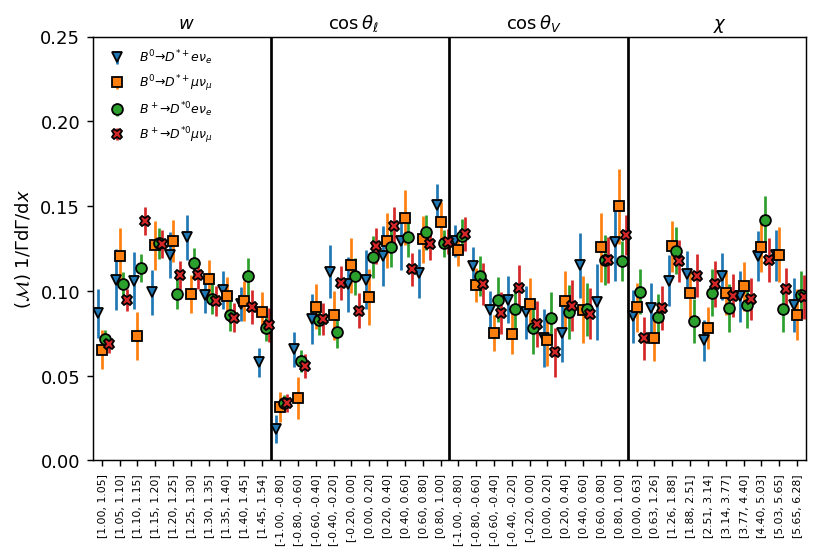

In [16]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))
total_rate = {}

for i, channel in enumerate([15, 16, 17, 18]):

    result = data[channel]["data"][:40]
    
    ax.errorbar(
        x=[x +(0.2*i - 0.2) for x in range(0, 40)],
        y=unp.nominal_values(result),
        yerr=unp.std_devs(result),
        marker=markers[channel], ls="", markeredgecolor='black', label=channel_label[channel],
    )

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 0.25)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")

plt.tight_layout()
#plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum_normalized.pdf", transparent=True)
#plt.savefig(f"{plotoutdir}/acceptance_corrected_m_spectrum_normalized.png", transparent=True)   
plt.show()
plt.close()

In [17]:
shapes = fit_results[:160]
shapes_stat = fit_results_stat[:160]

In [18]:
for i in reversed(range(9, 160, 10)):
    shapes = np.delete(shapes, i)
    shapes_stat = np.delete(shapes_stat, i)

In [19]:
def get_average(chi2_average):
    m_average = Minuit(chi2_average, data[15]["central_fit"][:-1])
    m_average.migrad()  # run optimiser
    m_average.hesse()   # run covariance estimator
    return m_average

In [20]:
m = shapes
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_average = get_average(chi2_average)

m = shapes[:2*36]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bzero_average = get_average(chi2_average)

m = shapes[2*36:]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bplus_average = get_average(chi2_average)

m = np.array([*shapes[0:36], *shapes[2*36:3*36]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_electron_average = get_average(chi2_average)

m = np.array([*shapes[36:2*36], *shapes[3*36:]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_muon_average = get_average(chi2_average)

/tmp/ipykernel_72770/3721315730.py:3: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_average.migrad()  # run optimiser


In [21]:
m = shapes_stat
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_average_stat = get_average(chi2_average)

m = shapes_stat[:2*36]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bzero_average_stat = get_average(chi2_average)

m = shapes_stat[2*36:]
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_Bplus_average_stat = get_average(chi2_average)

m = np.array([*shapes_stat[0:36], *shapes_stat[2*36:3*36]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_electron_average_stat = get_average(chi2_average)

m = np.array([*shapes_stat[36:2*36], *shapes_stat[3*36:]])
invC = scipy.linalg.inv(covariance_matrix(m))
def chi2_average(x):
    x_ = np.array((len(m) // 36) * [*x])
    delta = unp.nominal_values(m) - x_
    return delta @ invC @ delta
m_muon_average_stat = get_average(chi2_average)

/tmp/ipykernel_72770/3721315730.py:3: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_average.migrad()  # run optimiser


In [22]:
def get_full_spectrum(m):
    average = correlated_values(np.array(m.values), np.array(m.covariance))
    f0 = 1 - sum(average[ 0: 9])
    f1 = 1 - sum(average[ 9:18])
    f2 = 1 - sum(average[18:27])
    f3 = 1 - sum(average[27:36])
    return np.array([
        *average[ 0: 9], f0, 
        *average[ 9:18], f1, 
        *average[18:27], f2, 
        *average[27:36], f3, 
    ])

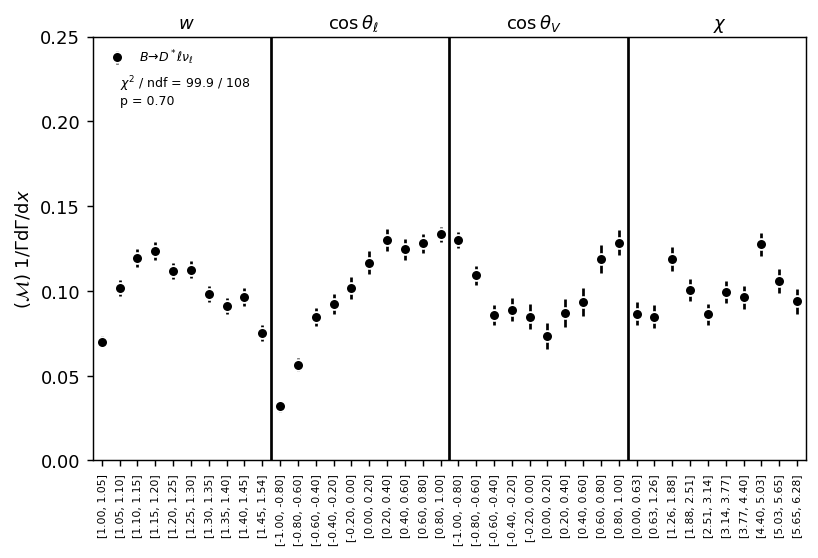

In [23]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)
result_stat = get_full_spectrum(m_average_stat)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result),
    yerr=unp.std_devs(result),
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

# ax.errorbar(
#     x=[x for x in range(0, 40)],
#     y=unp.nominal_values(result_stat),
#     yerr=unp.std_devs(result_stat),
#     marker='.', color="tab:blue", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
# )


make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 0.25)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(1, 0.22, f"$\chi^2$ / ndf = {m_average.fval:.1f} / {4*36-36}", size="x-small")
ax.text(1, 0.21, f"p = {scipy.stats.chi2.sf(m_average.fval, df=4*36-36):.2f}", size="x-small")
#ax.text(1, 0.18, f"$\chi^2$ / ndf = {m_average_stat.fval:.1f} / {4*36-36}", size="x-small")
#ax.text(1, 0.17, f"p = {scipy.stats.chi2.sf(m_average_stat.fval, df=4*36-36):.2f}", size="x-small")

plt.savefig("Average.pdf", transparent=True)
plt.savefig("Average.png", transparent=True) 
plt.tight_layout()
plt.show()
plt.close()

In [24]:
def chi2_table_columns(a, b, dof):
    return [
        f"{a.fval:.1f} / {dof}", 
        f"{scipy.stats.chi2.sf(a.fval, df=dof):.2f}", 
        f"{b.fval:.1f} / {dof}",
        f"{scipy.stats.chi2.sf(b.fval, df=dof):.2f}", 
    ]

In [25]:
table = pd.DataFrame.from_dict({
    channel_label["all"]: chi2_table_columns(m_average, m_average_stat, 3*36),
    channel_label["B0"]: chi2_table_columns(m_Bzero_average, m_Bzero_average_stat, 1*36),
    channel_label["B+"]: chi2_table_columns(m_Bplus_average, m_Bplus_average_stat, 1*36),
    channel_label["e"]: chi2_table_columns(m_electron_average, m_electron_average_stat, 1*36),
    channel_label["mu"]: chi2_table_columns(m_muon_average, m_muon_average_stat, 1*36),
}, columns=[r"$\chi^2$ / dof", "p", r"$\chi^2_\mathrm{stat}$ / dof", r"$p_\mathrm{stat}$"], orient="index")
table

,$\chi^2$ / dof,p,$\chi^2_\mathrm{stat}$ / dof,$p_\mathrm{stat}$
$B \to D^{*} \ell \nu_\ell$,99.9 / 108,0.70,104.6 / 108,0.57
$B^0 \to D^{*+} \ell \nu_\ell$,29.1 / 36,0.79,30.3 / 36,0.74
$B^+ \to D^{*0} \ell \nu_\ell$,26.3 / 36,0.88,27.3 / 36,0.85
"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",35.1 / 36,0.51,36.8 / 36,0.43
"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",42.7 / 36,0.21,44.2 / 36,0.16


In [26]:
table.to_latex(buf="Averages.tex", escape=False)

In [27]:
average           = get_full_spectrum(m_average)
average_Bzero     = get_full_spectrum(m_Bzero_average)
average_Bplus     = get_full_spectrum(m_Bplus_average)
average_Belectron = get_full_spectrum(m_electron_average)
average_Bmuon     = get_full_spectrum(m_muon_average)

In [28]:
average_stat           = get_full_spectrum(m_average_stat)
average_Bzero_stat     = get_full_spectrum(m_Bzero_average_stat)
average_Bplus_stat     = get_full_spectrum(m_Bplus_average_stat)
average_Belectron_stat = get_full_spectrum(m_electron_average_stat)
average_Bmuon_stat     = get_full_spectrum(m_muon_average_stat)

In [29]:
def nice_output_transform(obs, obs_stat):
    return f"${obs.n:.3f} \pm {obs_stat.s:.3f} \pm {(obs.s**2 - obs_stat.s**2) ** 0.5:.3f}$"

In [30]:
R_Bzero = fit_results[-4] / fit_results[-3]
R_Bplus = fit_results[-2] / fit_results[-1]
R_B     = (fit_results[-4] + fit_results[-2]) / (fit_results[-1] + fit_results[-3])
Rs      = np.array([R_Bzero, R_Bplus, R_B])

In [31]:
R_Bzero_stat = fit_results_stat[-4] / fit_results_stat[-3]
R_Bplus_stat = fit_results_stat[-2] / fit_results_stat[-1]
R_B_stat     = (fit_results_stat[-4] + fit_results_stat[-2]) / (fit_results_stat[-1] + fit_results_stat[-3])
Rs_stat      = np.array([R_Bzero_stat, R_Bplus_stat, R_B_stat])

In [32]:
AFB_15 = sum(fit_results[0*40 + 15: 0*40 + 20]) - sum(fit_results[0*40 + 10:0*40 + 15])
AFB_16 = sum(fit_results[1*40 + 15: 1*40 + 20]) - sum(fit_results[1*40 + 10:1*40 + 15])
AFB_17 = sum(fit_results[2*40 + 15: 2*40 + 20]) - sum(fit_results[2*40 + 10:2*40 + 15])
AFB_18 = sum(fit_results[3*40 + 15: 3*40 + 20]) - sum(fit_results[3*40 + 10:3*40 + 15])
AFB_e = sum(average_Belectron[15:20]) - sum(average_Belectron[10:15])
AFB_mu = sum(average_Bmuon[15:20]) - sum(average_Bmuon[10:15])
AFBs = np.array([AFB_15, AFB_16, AFB_17, AFB_18, AFB_e, AFB_mu])

In [33]:
AFB_15_stat = sum(fit_results_stat[0*40 + 15: 0*40 + 20]) - sum(fit_results_stat[0*40 + 10:0*40 + 15])
AFB_16_stat = sum(fit_results_stat[1*40 + 15: 1*40 + 20]) - sum(fit_results_stat[1*40 + 10:1*40 + 15])
AFB_17_stat = sum(fit_results_stat[2*40 + 15: 2*40 + 20]) - sum(fit_results_stat[2*40 + 10:2*40 + 15])
AFB_18_stat = sum(fit_results_stat[3*40 + 15: 3*40 + 20]) - sum(fit_results_stat[3*40 + 10:3*40 + 15])
AFB_e_stat  = sum(average_Belectron_stat[15:20]) - sum(average_Belectron_stat[10:15])
AFB_mu_stat = sum(average_Bmuon_stat[15:20]) - sum(average_Bmuon_stat[10:15])
AFBs_stat   = np.array([AFB_15_stat, AFB_16_stat, AFB_17_stat, AFB_18_stat, AFB_e_stat, AFB_mu_stat])

In [34]:
deltaAFB_Bzero = AFB_16 - AFB_15
deltaAFB_Bplus = AFB_18 - AFB_17
deltaAFB_B     = AFB_mu - AFB_e
deltaAFBs      = np.array([deltaAFB_Bzero, deltaAFB_Bplus, deltaAFB_B])

In [35]:
deltaAFB_Bzero_stat = AFB_16_stat - AFB_15_stat
deltaAFB_Bplus_stat = AFB_18_stat - AFB_17_stat
deltaAFB_B_stat     = AFB_mu_stat - AFB_e_stat
deltaAFBs_stat      = np.array([deltaAFB_Bzero_stat, deltaAFB_Bplus_stat, deltaAFB_B_stat])

In [36]:
def predict_normalized_rate(F_L, l, u):
    return scipy.integrate.quad(lambda x: 1.5 * ((F_L * x**2) + 0.5 * (1 - F_L) * (1 - x**2)), l, u)[0]

def get_FL(cosVshape):
    cosVshape = cosVshape
    C = statsmodels.stats.correlation_tools.cov_nearest(covariance_matrix(cosVshape), threshold=1e-3)
    invC = scipy.linalg.inv(C)
    bins = np.array([-1. , -0.8, -0.6, -0.4, -0.2,  0.,  0.2,  0.4,  0.6,  0.8,  1. ])
    def chi2_FL(x):
        x_ = np.array([predict_normalized_rate(x, l, u) for l, u in zip(bins, bins[1:])])
        delta = unp.nominal_values(cosVshape) - x_
        return delta @ invC @ delta

    m_FL = Minuit(chi2_FL, 0)
    m_FL.migrad()  # run optimiser
    m_FL.hesse()   # run covariance estimator
    return m_FL

In [37]:
FL_15 = ufloat(np.array(get_FL(fit_results[0*40+20:0*40+30]).values), np.array(get_FL(fit_results[0*40+20:0*40+30]).covariance[0, 0]**0.5))
FL_16 = ufloat(np.array(get_FL(fit_results[1*40+20:1*40+30]).values), np.array(get_FL(fit_results[1*40+20:1*40+30]).covariance[0, 0]**0.5))
FL_17 = ufloat(np.array(get_FL(fit_results[2*40+20:2*40+30]).values), np.array(get_FL(fit_results[2*40+20:2*40+30]).covariance[0, 0]**0.5))
FL_18 = ufloat(np.array(get_FL(fit_results[3*40+20:3*40+30]).values), np.array(get_FL(fit_results[3*40+20:3*40+30]).covariance[0, 0]**0.5))
FL_e = ufloat(np.array(get_FL(average_Belectron[20:30]).values), np.array(get_FL(average_Belectron[20:30]).covariance[0, 0]**0.5))
FL_mu = ufloat(np.array(get_FL(average_Bmuon[20:30]).values), np.array(get_FL(average_Bmuon[20:30]).covariance[0, 0]**0.5))
FL_Bzero = ufloat(np.array(get_FL(average_Bzero[20:30]).values), np.array(get_FL(average_Bzero[20:30]).covariance[0, 0]**0.5))
FL_Bplus = ufloat(np.array(get_FL(average_Bplus[20:30]).values), np.array(get_FL(average_Bplus[20:30]).covariance[0, 0]**0.5))
FL = ufloat(np.array(get_FL(average[20:30]).values), np.array(get_FL(average[20:30]).covariance[0, 0]**0.5))
FLs = np.array([FL_15, FL_16, FL_17, FL_18, FL_e, FL_mu, FL_Bzero, FL_Bplus, FL])

/tmp/ipykernel_72770/2400311376.py:15: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_FL.migrad()  # run optimiser


In [38]:
FL_15_stat = ufloat(np.array(get_FL(fit_results_stat[0*40+20:0*40+30]).values), np.array(get_FL(fit_results_stat[0*40+20:0*40+30]).covariance[0, 0]**0.5))
FL_16_stat = ufloat(np.array(get_FL(fit_results_stat[1*40+20:1*40+30]).values), np.array(get_FL(fit_results_stat[1*40+20:1*40+30]).covariance[0, 0]**0.5))
FL_17_stat = ufloat(np.array(get_FL(fit_results_stat[2*40+20:2*40+30]).values), np.array(get_FL(fit_results_stat[2*40+20:2*40+30]).covariance[0, 0]**0.5))
FL_18_stat = ufloat(np.array(get_FL(fit_results_stat[3*40+20:3*40+30]).values), np.array(get_FL(fit_results_stat[3*40+20:3*40+30]).covariance[0, 0]**0.5))
FL_e_stat = ufloat(np.array(get_FL(average_Belectron_stat[20:30]).values), np.array(get_FL(average_Belectron_stat[20:30]).covariance[0, 0]**0.5))
FL_mu_stat = ufloat(np.array(get_FL(average_Bmuon_stat[20:30]).values), np.array(get_FL(average_Bmuon_stat[20:30]).covariance[0, 0]**0.5))
FL_Bzero_stat = ufloat(np.array(get_FL(average_Bzero_stat[20:30]).values), np.array(get_FL(average_Bzero_stat[20:30]).covariance[0, 0]**0.5))
FL_Bplus_stat = ufloat(np.array(get_FL(average_Bplus_stat[20:30]).values), np.array(get_FL(average_Bplus_stat[20:30]).covariance[0, 0]**0.5))
FL_stat = ufloat(np.array(get_FL(average_stat[20:30]).values), np.array(get_FL(average_stat[20:30]).covariance[0, 0]**0.5))
FLs = np.array([FL_15_stat, FL_16_stat, FL_17_stat, FL_18_stat, FL_e_stat, FL_mu_stat, FL_Bzero_stat, FL_Bplus_stat, FL_stat])

/tmp/ipykernel_72770/2400311376.py:15: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_FL.migrad()  # run optimiser


In [39]:
deltaFL_Bzero = FL_16 - FL_15
deltaFL_Bplus = FL_18 - FL_17
deltaFL_B     = FL_mu - FL_e
deltaFLs      = np.array([deltaFL_Bzero, deltaFL_Bplus, deltaFL_B])

In [40]:
deltaFL_Bzero_stat = FL_16_stat - FL_15_stat
deltaFL_Bplus_stat = FL_18_stat - FL_17_stat
deltaFL_B_stat     = FL_mu_stat - FL_e_stat
deltaFLs_stat      = np.array([deltaFL_Bzero_stat, deltaFL_Bplus_stat, deltaFL_B_stat])

In [41]:
table = {}
table[r"$F_L^{D^{*}}$"] = [
    nice_output_transform(FL_15, FL_15_stat), 
    nice_output_transform(FL_16, FL_16_stat), 
    nice_output_transform(FL_17, FL_17_stat), 
    nice_output_transform(FL_18, FL_18_stat),
    nice_output_transform(FL_e, FL_e_stat),
    nice_output_transform(FL_mu, FL_mu_stat),
    nice_output_transform(FL_Bzero, FL_Bzero_stat),
    nice_output_transform(FL_Bplus, FL_Bplus_stat),
    nice_output_transform(FL, FL_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"], channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$F_L^{D^{*}}$
$B^0 \to D^{*+} e \nu_e$,$0.466 \pm 0.028 \pm 0.006$
$B^0 \to D^{*+} \mu \nu_\mu$,$0.475 \pm 0.027 \pm 0.004$
$B^+ \to D^{*0} e \nu_e$,$0.460 \pm 0.025 \pm 0.005$
$B^+ \to D^{*0} \mu \nu_\mu$,$0.481 \pm 0.024 \pm 0.004$
"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",$0.465 \pm 0.019 \pm 0.004$
"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",$0.482 \pm 0.018 \pm 0.003$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.471 \pm 0.019 \pm 0.003$
$B^+ \to D^{*0} \ell \nu_\ell$,$0.470 \pm 0.018 \pm 0.003$
$B \to D^{*} \ell \nu_\ell$,$0.473 \pm 0.013 \pm 0.002$


In [42]:
table.to_latex(buf="FL.tex", escape=False)

In [43]:
table = {}
table[r"$\Delta F_L^{D^{*}}$"] = [
    nice_output_transform(deltaFL_Bzero, deltaFL_Bzero_stat), 
    nice_output_transform(deltaFL_Bplus, deltaFL_Bplus_stat), 
    nice_output_transform(deltaFL_B, deltaFL_B_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$\Delta F_L^{D^{*}}$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.008 \pm 0.039 \pm 0.007$
$B^+ \to D^{*0} \ell \nu_\ell$,$0.022 \pm 0.035 \pm 0.007$
$B \to D^{*} \ell \nu_\ell$,$0.017 \pm 0.026 \pm 0.005$


In [44]:
table.to_latex(buf="DeltaFL.tex", escape=False)

In [45]:
table = {}
table[r"$A_\mathrm{FB}$"] = [
    nice_output_transform(AFB_15, AFB_15_stat), 
    nice_output_transform(AFB_16, AFB_16_stat), 
    nice_output_transform(AFB_17, AFB_17_stat), 
    nice_output_transform(AFB_18, AFB_18_stat),
    nice_output_transform(AFB_e, AFB_e_stat),
    nice_output_transform(AFB_mu, AFB_mu_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"]], orient="index").transpose()
table

,$A_\mathrm{FB}$
$B^0 \to D^{*+} e \nu_e$,$0.235 \pm 0.034 \pm 0.009$
$B^0 \to D^{*+} \mu \nu_\mu$,$0.280 \pm 0.035 \pm 0.006$
$B^+ \to D^{*0} e \nu_e$,$0.280 \pm 0.023 \pm 0.006$
$B^+ \to D^{*0} \mu \nu_\mu$,$0.269 \pm 0.023 \pm 0.005$
"$B^{(0,+)} \to D^{*(+,0)} e \nu_e$",$0.261 \pm 0.019 \pm 0.006$
"$B^{(0,+)} \to D^{*(+,0)} \mu \nu_\mu$",$0.271 \pm 0.019 \pm 0.004$


In [46]:
table.to_latex(buf="AFB.tex", escape=False)

In [47]:
table = {}
table[r"$\Delta A_\mathrm{FB}$"] = [
    nice_output_transform(deltaAFB_Bzero, deltaAFB_Bzero_stat), 
    nice_output_transform(deltaAFB_Bplus, deltaAFB_Bplus_stat), 
    nice_output_transform(deltaAFB_B, deltaAFB_B_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$\Delta A_\mathrm{FB}$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.046 \pm 0.049 \pm 0.010$
$B^+ \to D^{*0} \ell \nu_\ell$,$-0.011 \pm 0.033 \pm 0.008$
$B \to D^{*} \ell \nu_\ell$,$0.010 \pm 0.027 \pm 0.007$


In [48]:
table.to_latex(buf="DeltaAFB.tex", escape=False)

In [49]:
table = {}
table[r"$R_{{e\mu}}$"] = [
    nice_output_transform(R_Bzero, R_Bzero_stat), 
    nice_output_transform(R_Bplus, R_Bplus_stat), 
    nice_output_transform(R_B    , R_B_stat),
]
table = pd.DataFrame.from_dict(table, columns=[channel_label["B0"], channel_label["B+"], channel_label["all"]], orient="index").transpose()
table

,$R_{{e\mu}}$
$B^0 \to D^{*+} \ell \nu_\ell$,$0.988 \pm 0.039 \pm 0.025$
$B^+ \to D^{*0} \ell \nu_\ell$,$0.967 \pm 0.026 \pm 0.022$
$B \to D^{*} \ell \nu_\ell$,$0.977 \pm 0.023 \pm 0.023$


In [50]:
table.to_latex(buf="Remu.tex", escape=False)

No handles with labels found to put in legend.
/tmp/ipykernel_72770/422671357.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


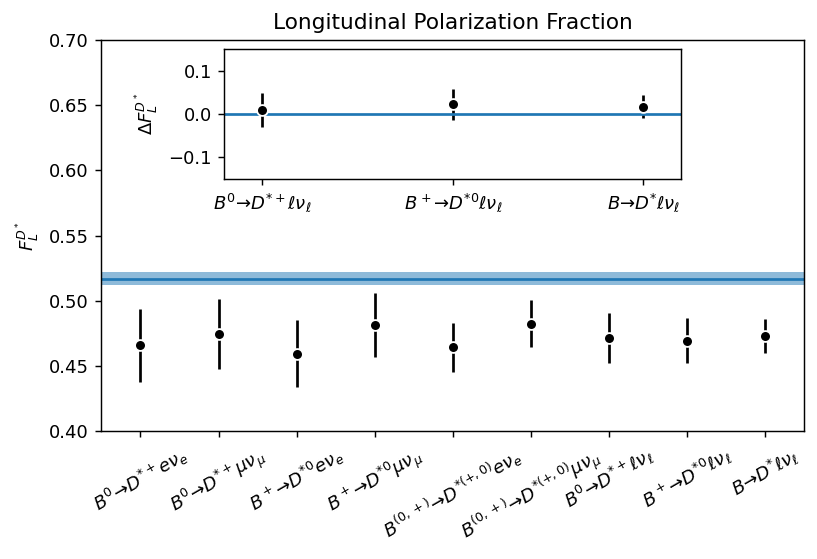

In [51]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))   

ax.errorbar(
    x=range(9),
    y=unp.nominal_values(FLs),
    yerr=unp.std_devs(FLs),
    ls="", marker="o", markeredgecolor="white", color="black"
)

ax.axhline(0.517, color="tab:blue")
ax.fill_between(np.linspace(-0.5, 9.5), 0.517-0.005, 0.517+0.005, alpha=0.5)

#ax.fill_between(
#    np.linspace(-0.5, 5.5),
#    (rate[15].DGamma_DcosL(0, 1) - rate[15].DGamma_DcosL(-1, 0)) / (rate[15].DGamma_DcosL(0, 1) + rate[15].DGamma_DcosL(-1, 0)),
#    (rate[17].DGamma_DcosL(0, 1) - rate[17].DGamma_DcosL(-1, 0)) / (rate[17].DGamma_DcosL(0, 1) + rate[17].DGamma_DcosL(-1, 0)),
#    color="black", alpha=0.5, 
#    )

#make_plot_pretty(ax, bin_edges_all)
ax.set_ylabel("$F_L^{D^*}$")
ax.set_xlim(-0.5, 8.5)
ax.set_ylim(0.4, 0.7)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
ax.set_xticks(range(0, 9))
ax.set_xticklabels([channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"], channel_label["B0"], channel_label["B+"], channel_label["all"]], rotation=30)

parent_axes = plt.gca()
inside_axis = inset_axes(parent_axes,
                    width="65%", # width = 30% of parent_bbox
                    height=1, # height : 1 inch
                    loc="upper center")

inside_axis.errorbar(
    x=range(3),
    y=unp.nominal_values(deltaFLs),
    yerr=unp.std_devs(deltaFLs),
    ls="", marker="o", markeredgecolor="white", color="black"
)
inside_axis.axhline(0.0, color="tab:blue")

inside_axis.set_xlim(-0.2, 2.2)
inside_axis.set_ylim(-0.15, 0.15)
inside_axis.set_ylabel("$\Delta F_L^{D^*}$")# = F_L^{D^*\mu} - F_L^{D^*e}$")
inside_axis.set_xticks(range(0, 3))
inside_axis.set_xticklabels([channel_label[channel] for channel in ["B0", "B+", "all"]])

ax.set_title("Longitudinal Polarization Fraction")

#plt.text(1.5, 0., "Preliminary", size=50, rotation=-25.,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig("FL.pdf", transparent=True)
plt.savefig("FL.png", transparent=True) 
plt.show()
plt.close()

No handles with labels found to put in legend.
/tmp/ipykernel_72770/2163945788.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


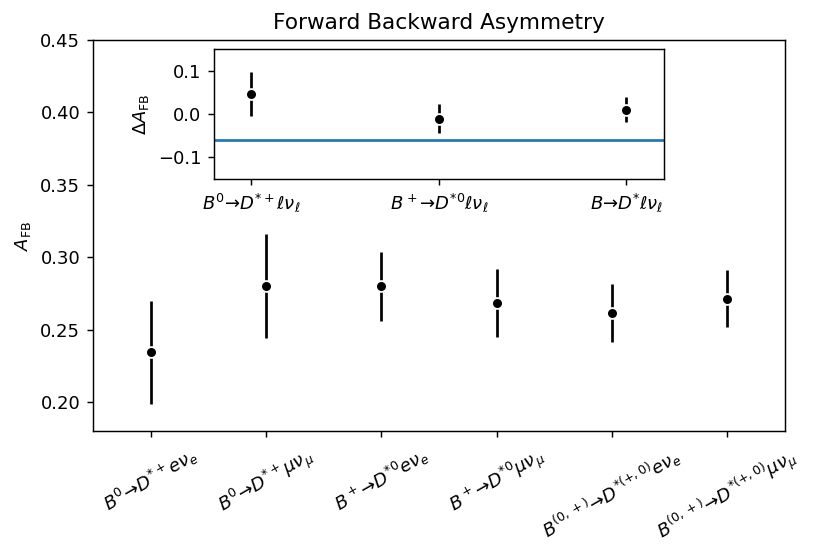

In [52]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))   

ax.errorbar(
    x=range(6),
    y=unp.nominal_values(AFBs),
    yerr=unp.std_devs(AFBs),
    ls="", marker="o", markeredgecolor="white", color="black"
)

#ax.fill_between(
#    np.linspace(-0.5, 5.5),
#    (rate[15].DGamma_DcosL(0, 1) - rate[15].DGamma_DcosL(-1, 0)) / (rate[15].DGamma_DcosL(0, 1) + rate[15].DGamma_DcosL(-1, 0)),
#    (rate[17].DGamma_DcosL(0, 1) - rate[17].DGamma_DcosL(-1, 0)) / (rate[17].DGamma_DcosL(0, 1) + rate[17].DGamma_DcosL(-1, 0)),
#    color="black", alpha=0.5, 
#    )

#make_plot_pretty(ax, bin_edges_all)
ax.set_ylabel("$A_\mathrm{FB}$")
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(0.18, 0.45)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')
ax.set_xticks(range(0, 6))
ax.set_xticklabels([channel_label[channel] for channel in channels] + [channel_label["e"], channel_label["mu"]], rotation=30)

parent_axes = plt.gca()
inside_axis = inset_axes(parent_axes,
                    width="65%", # width = 30% of parent_bbox
                    height=1, # height : 1 inch
                    loc="upper center")

inside_axis.errorbar(
    x=range(3),
    y=unp.nominal_values(deltaAFBs),
    yerr=unp.std_devs(deltaAFBs),
    ls="", marker="o", markeredgecolor="white", color="black"
)
inside_axis.axhline(-0.06, color="tab:blue")

inside_axis.set_xlim(-0.2, 2.2)
inside_axis.set_ylim(-0.15, 0.15)
inside_axis.set_ylabel("$\Delta A_\mathrm{FB}$")# = A_\mathrm{FB}^\mu - A_\mathrm{FB}^e$")
inside_axis.set_xticks(range(0, 3))
inside_axis.set_xticklabels([channel_label[channel] for channel in ["B0", "B+", "all"]])

ax.set_title("Forward Backward Asymmetry")

#plt.text(1.5, 0., "Preliminary", size=50, rotation=-25.,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig("AFB.pdf", transparent=True)
plt.savefig("AFB.png", transparent=True) 
plt.show()
plt.close()

No handles with labels found to put in legend.


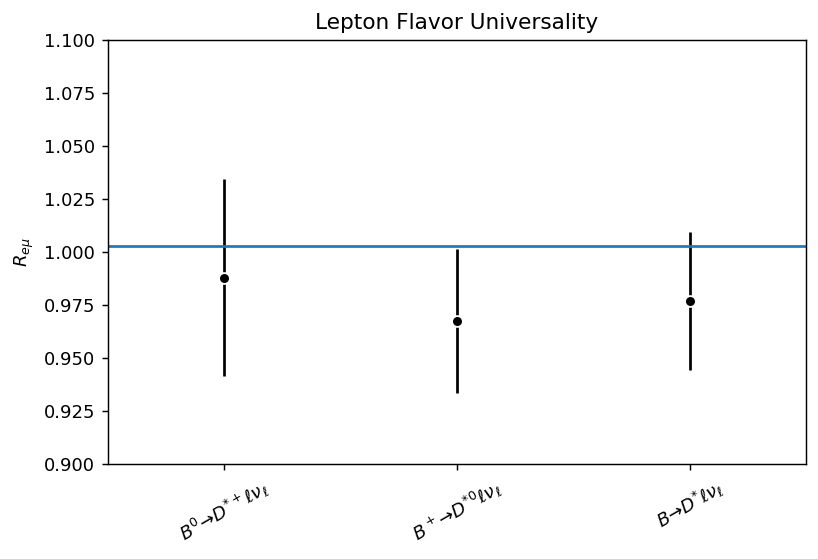

In [53]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))   
    
ax.errorbar(
    x=range(3),
    y=unp.nominal_values(Rs),
    yerr=unp.std_devs(Rs),
    ls="", marker="o", markeredgecolor="white", color="black"
)
ax.axhline(1.0026, color="tab:blue")
ax.fill_between(np.linspace(-0.2, 2.2), 1.0026 + 0.0001, 1.0026 - 0.0001, alpha=0.5)


ax.set_xlim(-0.2, 2.2)
ax.set_ylim(0.9, 1.1)
ax.set_ylabel("$\Delta A_\mathrm{FB} = A_\mathrm{FB}^\mu - A_\mathrm{FB}^e$")
ax.set_xticks(range(0, 3))
ax.set_xticklabels([channel_label[channel] for channel in ["B0", "B+", "all"]], rotation=30)

#make_plot_pretty(ax, bin_edges_all)
ax.set_ylabel("$R_{e\mu}$")
ax.set_xlim(-0.5, 2.5)
#ax.set_ylim(0.18, 0.42)
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

ax.set_title("Lepton Flavor Universality")

#plt.text(2, 1.02, "Preliminary", size=50,
#         ha="right", va="top",
#         bbox=dict(boxstyle="square",
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   alpha=0.3
#                   )
#         )

plt.tight_layout()
plt.savefig("Remu.pdf", transparent=True)
plt.savefig("Remu.png", transparent=True) 
plt.show()
plt.close()

#### Fit Matrix

- [x] Data Only Fits with BGL and CLN to study the data (stat. only)
    - [x] Each channel 
    - [x] Average B+ channels 
    - [x] Average B0 channels 
    - [x] Average all channels 
    - [x] Average e and mu channels 
- [ ] Data Only Fits with BGL and CLN to study the data (stat. + sys.)
- [ ] Average spectrum / fit all 
    - [ ] Nested hypothesis test for number of coefficients to determine number of BGL coefficients
    - [ ] Include theory constraints into Chi2 Function, Vcb as free parameter, eta_ew as correct value https://arxiv.org/pdf/2105.14019.pdf, data in arxiv available. Bad chi2 expected
      - [ ] BGL paramter directly as "nuisance" constraints 
      - [x] h_A1(1)
      - [x] h_A1(1.03), h_A1(1.1), h_A1(1.17) available in auxilary files, correlation!
      - [ ] add h_V, h_A2, h_A3 --> this needs implementation in effort2

In [54]:
def theory_term_disabled_cln(rate, *x):
    return 0
print(theory_term_disabled_cln(rate[15], *test))

def theory_term_A_cln(rate, *x):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    
    return (rate.FF.h_A1(1.0) - hA1.nominal_value) ** 2 / hA1.std_dev ** 2
print(theory_term_A_cln(rate[15], *test))

def theory_term_B_cln(rate, *x):
    rate_cln[channel].Vcb = x[4]
    rate_cln[channel].FF.rho2 = x[0]
    rate_cln[channel].FF.R1_1 = x[1]
    rate_cln[channel].FF.R2_1 = x[2]
    rate_cln[channel].FF.h_A1_1 = x[3]
    
    delta = np.array([rate.FF.h_A1(1.03), rate.FF.h_A1(1.10), rate.FF.h_A1(1.17)]) - unp.nominal_values(hA1_all)
    return delta @ np.linalg.inv(covariance_matrix(hA1_all)) @ delta
print(theory_term_B_cln(rate[15], *test))

theory_term_cln = theory_term_A_cln


def chi2_normalized_minuit_cln(rho2, R1_1, R2_1, h_A1_1):
    Vcb = 1
    chi2 = 0
    
    for channel in [15]: #channels:
        delta = data[channel]["central_fit"][:-1] - transform(drop(theory_normalized_cln(np.array([rho2, R1_1, R2_1, h_A1_1, Vcb]), channel)))[:-1]
        chi2 += delta @ data[channel]["inv_covariance_fit"][:-1, :-1] @ delta 
    chi2 += theory_term_cln(rate_cln[channel], rho2, R1_1, R2_1, h_A1_1, Vcb)
    return chi2

m_cln = Minuit(chi2_normalized_minuit_cln, 
           rho2 = 1.03,
           R1_1 = 1.38,
           R2_1 = 0.97,
           h_A1_1 = 0.906
          )

m_cln.migrad()  # run optimiser
m_cln.hesse()   # run covariance estimator
m_cln

0
0.05667323063983685
0.07462368828821754


/tmp/ipykernel_72770/2506314082.py:46: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_cln.migrad()  # run optimiser


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 35.25                      │              Nfcn = 103              │
│ EDM = 1.58e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ rho2   │   1.18    │   0.26    │            │            │         │         │       │
│ 1 │ R1_1   │   1.46    │   0.21    │            │            │         │         │       │
│ 2 │ R2_1   │   1.01    │   0.17    │            │            │         │         │       │
│ 3 │ h_A1_1 │   0.909   │   0.017   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │      rho2      R1_1      R2_1    h_A1_1 │
├────────┼─────────────────────────────────────────┤
│   rho2 │    0.0697    0.0339   -0.0389  5.99e-10 │
│   R1_1 │    0.0339    0.0461   -0.0238  1.58e-10 │
│   R2_1 │   -0.0389   -0.0238    0.0271 -4.29e-10 │
│ h_A1_1 │  5.99e-10  1.58e-10 -4.29e-10  0.000283 │
└────────┴─────────────────────────────────────────┘

In [55]:
def theory_term_disabled(rate, *x):
    return 0
print(theory_term_disabled(rate[15], *test))

def theory_term_A(rate, *x):
    rate.Vcb = x[9]
    # rate.eta_EW = 1
    rate.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    
    return (rate.FF.h_A1(1.0) - hA1.nominal_value) ** 2 / hA1.std_dev ** 2
print(theory_term_A(rate[15], *test))

def theory_term_B(rate, *x):
    rate.Vcb = x[9]
    # rate.eta_EW = 1
    rate.FF.set_expansion_coefficients(x[:3], x[3:6], x[6:9])
    
    delta = np.array([rate.FF.h_A1(1.03), rate.FF.h_A1(1.10), rate.FF.h_A1(1.17)]) - unp.nominal_values(hA1_all)
    return delta @ np.linalg.inv(covariance_matrix(hA1_all)) @ delta
print(theory_term_B(rate[15], *test))

theory_term = theory_term_A


def chi2_normalized_minuit(a0, a1, a2, b0, b1, b2, c1, c2, c3):
    Vcb = 1
    chi2 = 0
    for channel in [15]: #channels:
        delta = data[channel]["central_fit"][:-1] - transform(drop(theory_normalized(np.array([a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]), channel)))[:-1]
        chi2 += delta @ data[channel]["inv_covariance_fit"][:-1, :-1] @ delta 
    chi2 += theory_term(rate[channel], a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb)
    return chi2

m = Minuit(chi2_normalized_minuit, 
           a0=test[0],
           a1=test[1],
           a2=0,
           b0=test[2],
           b1=test[3],
           b2=0,
           c1=test[4],
           c2=0,
           c3=0
          )

m.fixed["a2"] = True
m.fixed["b2"] = True
m.fixed["c2"] = True
m.fixed["c3"] = True
m.migrad()  # run optimiser
m.hesse()   # run covariance estimator
m

0
0.05667323063983685
19.165643272475652


/tmp/ipykernel_72770/2827897154.py:50: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.73                      │              Nfcn = 256              │
│ EDM = 1.62e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a0   │   0.003   │   0.009   │            │            │         │         │       │
│ 1 │ a1   │   0.99    │   0.29    │            │            │         │         │       │
│ 2 │ a2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 3 │ b0   │ 13.17e-3  │  0.24e-3  │            │            │         │         │       │
│ 4 │ b1   │   -0.10   │   0.06    │            │            │         │         │       │
│ 5 │ b2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 6 │ c1   │  -0.0109  │  0.0034   │            │            │         │         │       │
│ 7 │ c2   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 8 │ c3   │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│    │        a0        a1        a2        b0        b1        b2        c1        c2        c3 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ a0 │  8.65e-05   -0.0024         0  1.16e-08 -1.84e-05         0  1.17e-05         0         0 │
│ a1 │   -0.0024    0.0843         0  4.45e-06  -0.00477         0  -0.00055         0         0 │
│ a2 │         0         0         0         0         0         0         0         0         0 │
│ b0 │  1.16e-08  4.45e-06         0  5.94e-08 -4.62e-07         0 -4.92e-08         0         0 │
│ b1 │ -1.84e-05  -0.00477         0 -4.62e-07   0.00305         0  0.000131         0         0 │
│ b2 │         0         0         0         0         0         0         0         0         0 │
│ c1 │  1.17e-05  -0.00055         0 -4.92e-08  0.000131         0  1.12e-05         0         0 │
│ c2 │         0         0         0         0         0         0         0         0         0 │
│ c3 │         0         0         0         0         0         0         0         0         0 │
└────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [56]:
coefficients = correlated_values(np.array(m.values), np.array(m.covariance))
coefficients_cln = correlated_values(np.array(m_cln.values), np.array(m_cln.covariance))

In [57]:
def parse_bgl(c):
    corr = correlation_matrix(c)
    values = c
    index_picks = [0, 1, 3, 4, 6]
    return pd.DataFrame.from_dict({
        r"$a_0$": [values[0], *[corr[0, i] for i in index_picks]],
        r"$a_1$": [values[1], *[corr[1, i] for i in index_picks]],
        r"$b_0$": [values[3], *[corr[3, i] for i in index_picks]],
        r"$b_1$": [values[4], *[corr[4, i] for i in index_picks]],
        r"$c_1$": [values[6], *[corr[6, i] for i in index_picks]],
    }, columns=["Value", "Correlation", "", "", "", ""], orient="index").applymap(lambda x: f"{x:.2f}")

table = parse_bgl(coefficients)
table

/home/mapr/projects/eFFORT2/venv/lib/python3.8/site-packages/uncertainties/core.py:2953: RuntimeWarning: invalid value encountered in true_divide
  return cov_mat/std_devs/std_devs[numpy.newaxis].T


,Value,Correlation,,,,
$a_0$,0.00+/-0.01,1.00,-0.89,0.01,-0.04,0.37
$a_1$,0.99+/-0.29,-0.89,1.00,0.06,-0.30,-0.57
$b_0$,0.01+/-0.00,0.01,0.06,1.00,-0.03,-0.06
$b_1$,-0.10+/-0.06,-0.04,-0.30,-0.03,1.00,0.71
$c_1$,-0.01+/-0.00,0.37,-0.57,-0.06,0.71,1.00


In [86]:
sorted(np.real(scipy.linalg.eigvals(correlation_matrix(np.array([coefficients[0], coefficients[1], coefficients[3], coefficients[4], coefficients[6]])))))

[0.046192700322944126,
 0.22323565609548465,
 0.9944438994755935,
 1.2825704809294052,
 2.4535572631765734]

In [58]:
table.to_latex(buf="BGL221.tex", escape=False)

In [59]:
def parse_cln(c):
    corr = correlation_matrix(c)
    values = c
    
    return pd.DataFrame.from_dict({
        r"$\rho_2$": [values[0], *corr[0, :]],
        r"$R_1(1)$": [values[1], *corr[1, :]],
        r"$R_2(1)$": [values[2], *corr[2, :]],
        r"$h_{A_1}(1)$": [c[3], *corr[3, :]],
    }, columns=["Value", "Correlation", "", "", ""], orient="index").applymap(lambda x: f"{x:.2f}")

table = parse_cln(coefficients_cln)
table

,Value,Correlation,,,
$\rho_2$,1.18+/-0.26,1.00,0.60,-0.90,0.00
$R_1(1)$,1.46+/-0.21,0.60,1.00,-0.67,0.00
$R_2(1)$,1.01+/-0.16,-0.90,-0.67,1.00,-0.00
$h_{A_1}(1)$,0.91+/-0.02,0.00,0.00,-0.00,1.00


In [90]:
sorted(np.real(scipy.linalg.eigvals(correlation_matrix(coefficients_cln))))

[0.09791430335855537,
 0.4491843008225762,
 0.9999999999999821,
 2.452901395818887]

In [60]:
table.to_latex(buf="CLN.tex", escape=False)

In [61]:
bToDStarBGL = BToDStarBGL(
    m_B=5.27963,
    m_V=2.01026,
    exp_coeff_a = coefficients[0:3],
    exp_coeff_b = coefficients[3:6],
    exp_coeff_c = coefficients[6:9],
)

rate_bgl = BtoV(bToDStarBGL, 1)


bToDStarCLN = BToDStarCLN(
    m_B=m_Bzero,
    m_V=m_Dstarplus,
    h_A1_1 = coefficients_cln[3],
    rho2 = coefficients_cln[0],
    R1_1 = coefficients_cln[1],
    R2_1 = coefficients_cln[2],
)

rate_cln = BtoV(bToDStarCLN, 1)

In [62]:
w_range = np.linspace(*bToDStarBGL.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarBGL.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarBGL.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarBGL.kinematics.chi_range)

total_rate = rate_bgl.Gamma()
w_rate = [rate_bgl.dGamma_dw(w) / total_rate       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate = [rate_bgl.dGamma_dcosL(w) / total_rate * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
cosV_rate = [rate_bgl.dGamma_dcosV(w) / total_rate * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
chi_rate = [rate_bgl.dGamma_dchi(w) / total_rate   * (max(chi_range) - min(chi_range))   for w in chi_range]

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()

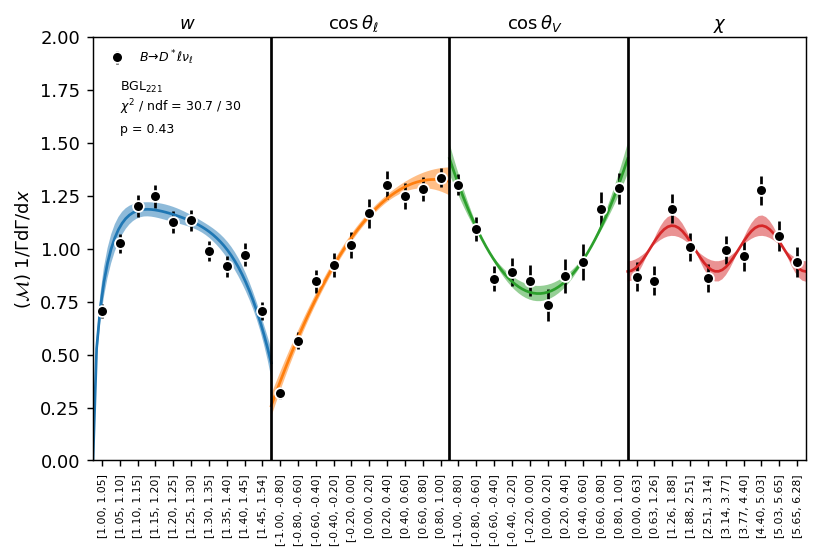

In [63]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate))
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate) + unp.std_devs(w_rate),
    unp.nominal_values(w_rate) - unp.std_devs(w_rate),
    alpha=0.5
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate))
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate) + unp.std_devs(cosL_rate),
    unp.nominal_values(cosL_rate) - unp.std_devs(cosL_rate),
    alpha=0.5
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate))
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate) + unp.std_devs(cosV_rate),
    unp.nominal_values(cosV_rate) - unp.std_devs(cosV_rate),
    alpha=0.5
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate))
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate) + unp.std_devs(chi_rate),
    unp.nominal_values(chi_rate) - unp.std_devs(chi_rate),
    alpha=0.5
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(1, 1.75, r"BGL$_{221}$", size="x-small")
ax.text(1, 1.65, f"$\chi^2$ / ndf = {m.fval:.1f} / 30", size="x-small")
ax.text(1, 1.55, f"p = {scipy.stats.chi2.sf(m.fval, df=36-6):.2f}", size="x-small")

plt.savefig("BGL221.pdf", transparent=True)
plt.savefig("BGL221.png", transparent=True)

plt.tight_layout()
plt.show()
plt.close()

In [64]:
w_range = np.linspace(*bToDStarCLN.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarCLN.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarCLN.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarCLN.kinematics.chi_range)

total_rate_cln = rate_cln.Gamma()
w_rate_cln = [rate_cln.dGamma_dw(w) / total_rate_cln       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate_cln = [rate_cln.dGamma_dcosL(w) / total_rate_cln * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
cosV_rate_cln = [rate_cln.dGamma_dcosV(w) / total_rate_cln * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
chi_rate_cln = [rate_cln.dGamma_dchi(w) / total_rate_cln   * (max(chi_range) - min(chi_range))   for w in chi_range]

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()

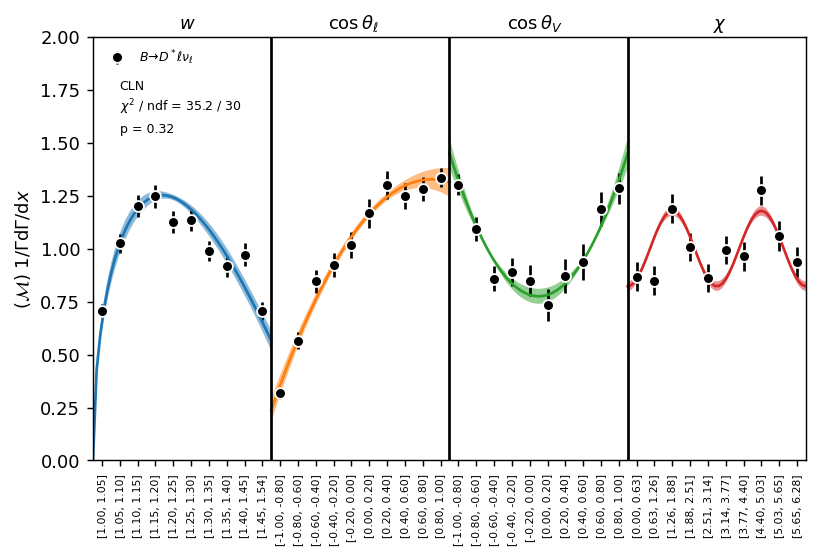

In [65]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_cln))
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_cln) + unp.std_devs(w_rate_cln),
    unp.nominal_values(w_rate_cln) - unp.std_devs(w_rate_cln),
    alpha=0.5
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_cln))
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_cln) + unp.std_devs(cosL_rate_cln),
    unp.nominal_values(cosL_rate_cln) - unp.std_devs(cosL_rate_cln),
    alpha=0.5
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate_cln))
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate_cln) + unp.std_devs(cosV_rate_cln),
    unp.nominal_values(cosV_rate_cln) - unp.std_devs(cosV_rate_cln),
    alpha=0.5
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_cln))
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate_cln) + unp.std_devs(chi_rate_cln),
    unp.nominal_values(chi_rate_cln) - unp.std_devs(chi_rate_cln),
    alpha=0.5
)

make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(1, 1.75, f"CLN", size="x-small")
ax.text(1, 1.65, f"$\chi^2$ / ndf = {m_cln.fval:.1f} / 30", size="x-small")
ax.text(1, 1.55, f"p = {scipy.stats.chi2.sf(m_cln.fval, df=36-4):.2f}", size="x-small")

plt.savefig("CLN.pdf", transparent=True)
plt.savefig("CLN.png", transparent=True)

plt.tight_layout()
plt.show()
plt.close()

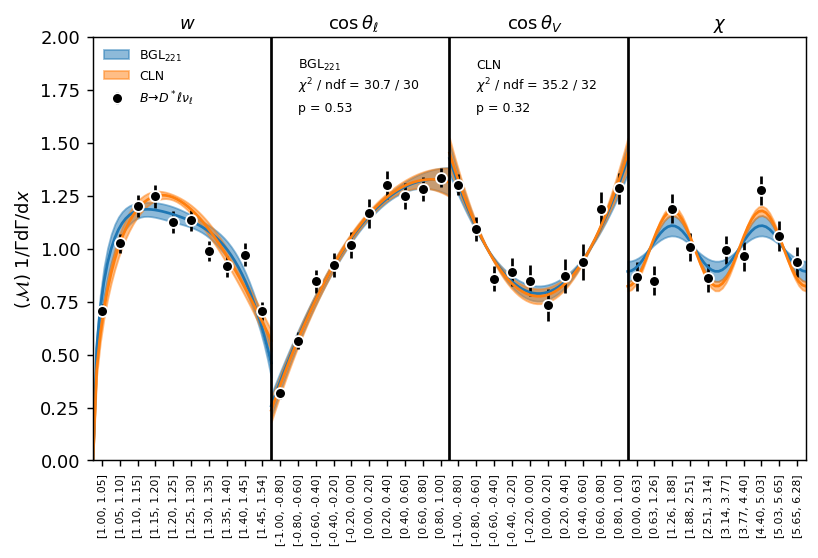

In [66]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate), color="tab:blue")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate) + unp.std_devs(w_rate),
    unp.nominal_values(w_rate) - unp.std_devs(w_rate),
    alpha=0.5, color="tab:blue", label=r"BGL$_{221}$"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate), color="tab:blue")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate) + unp.std_devs(cosL_rate),
    unp.nominal_values(cosL_rate) - unp.std_devs(cosL_rate),
    alpha=0.5, color="tab:blue"
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate), color="tab:blue")
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate) + unp.std_devs(cosV_rate),
    unp.nominal_values(cosV_rate) - unp.std_devs(cosV_rate),
    alpha=0.5, color="tab:blue"
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate), color="tab:blue")
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate) + unp.std_devs(chi_rate),
    unp.nominal_values(chi_rate) - unp.std_devs(chi_rate),
    alpha=0.5, color="tab:blue"
)


ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_cln) + unp.std_devs(w_rate_cln),
    unp.nominal_values(w_rate_cln) - unp.std_devs(w_rate_cln),
    alpha=0.5, color="tab:orange", label="CLN"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_cln) + unp.std_devs(cosL_rate_cln),
    unp.nominal_values(cosL_rate_cln) - unp.std_devs(cosL_rate_cln),
    alpha=0.5, color="tab:orange"
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate_cln) + unp.std_devs(cosV_rate_cln),
    unp.nominal_values(cosV_rate_cln) - unp.std_devs(cosV_rate_cln),
    alpha=0.5, color="tab:orange"
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate_cln) + unp.std_devs(chi_rate_cln),
    unp.nominal_values(chi_rate_cln) - unp.std_devs(chi_rate_cln),
    alpha=0.5, color="tab:orange"
)


make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
ax.text(11, 1.85, r"BGL$_{221}$", size="x-small")
ax.text(11, 1.75, f"$\chi^2$ / ndf = {m.fval:.1f} / 30", size="x-small")
ax.text(11, 1.65, f"p = {scipy.stats.chi2.sf(m.fval, df=36-4):.2f}", size="x-small")

ax.text(21, 1.85, f"CLN", size="x-small")
ax.text(21, 1.75, f"$\chi^2$ / ndf = {m_cln.fval:.1f} / 32", size="x-small")
ax.text(21, 1.65, f"p = {scipy.stats.chi2.sf(m_cln.fval, df=36-4):.2f}", size="x-small")

plt.savefig("BGL221vsCLN.pdf", transparent=True)
plt.savefig("BGL221vsCLN.png", transparent=True)

plt.tight_layout()
plt.show()
plt.close()

In [72]:
rate_cln.VplusA = 1
rate_cln.VminusA = 0
total_rate_cln_VplusA = rate_cln.Gamma()
w_rate_cln_VplusA = [rate_cln.dGamma_dw(w) / total_rate_cln       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate_cln_VplusA = [rate_cln.dGamma_dcosL(w) / total_rate_cln * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
cosV_rate_cln_VplusA = [rate_cln.dGamma_dcosV(w) / total_rate_cln * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
chi_rate_cln_VplusA = [rate_cln.dGamma_dchi(w) / total_rate_cln   * (max(chi_range) - min(chi_range))   for w in chi_range]
rate_cln.VplusA = 0
rate_cln.VminusA = 1

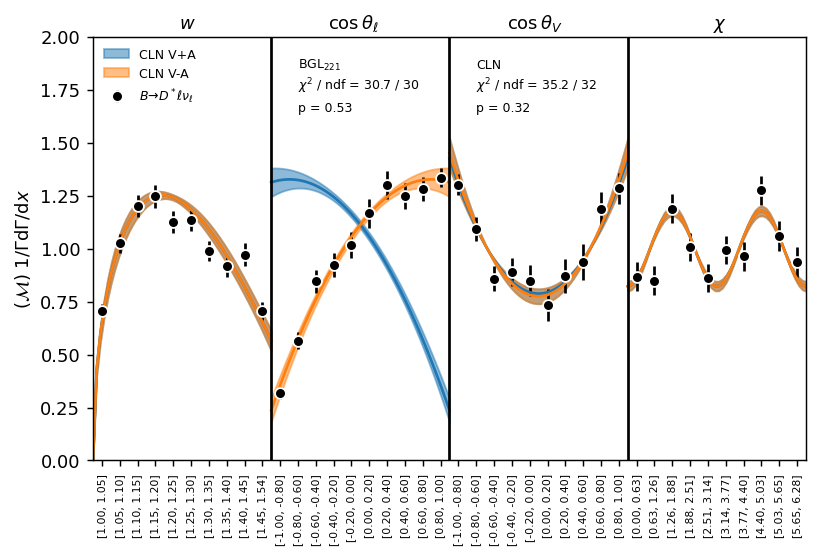

In [74]:
fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_cln_VplusA), color="tab:blue")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_cln_VplusA) + unp.std_devs(w_rate_cln_VplusA),
    unp.nominal_values(w_rate_cln_VplusA) - unp.std_devs(w_rate_cln_VplusA),
    alpha=0.5, color="tab:blue", label=r"CLN V+A"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_cln_VplusA), color="tab:blue")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_cln_VplusA) + unp.std_devs(cosL_rate_cln_VplusA),
    unp.nominal_values(cosL_rate_cln_VplusA) - unp.std_devs(cosL_rate_cln_VplusA),
    alpha=0.5, color="tab:blue"
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate), color="tab:blue")
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate_cln_VplusA) + unp.std_devs(cosV_rate_cln_VplusA),
    unp.nominal_values(cosV_rate_cln_VplusA) - unp.std_devs(cosV_rate_cln_VplusA),
    alpha=0.5, color="tab:blue"
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_cln_VplusA), color="tab:blue")
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate_cln_VplusA) + unp.std_devs(chi_rate_cln_VplusA),
    unp.nominal_values(chi_rate_cln_VplusA) - unp.std_devs(chi_rate_cln_VplusA),
    alpha=0.5, color="tab:blue"
)


ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace( 0-0.5, 10-0.5), 
    unp.nominal_values(w_rate_cln) + unp.std_devs(w_rate_cln),
    unp.nominal_values(w_rate_cln) - unp.std_devs(w_rate_cln),
    alpha=0.5, color="tab:orange", label="CLN V-A"
)
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(10-0.5, 20-0.5),
    unp.nominal_values(cosL_rate_cln) + unp.std_devs(cosL_rate_cln),
    unp.nominal_values(cosL_rate_cln) - unp.std_devs(cosL_rate_cln),
    alpha=0.5, color="tab:orange"
)
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(20-0.5, 30-0.5), 
    unp.nominal_values(cosV_rate_cln) + unp.std_devs(cosV_rate_cln),
    unp.nominal_values(cosV_rate_cln) - unp.std_devs(cosV_rate_cln),
    alpha=0.5, color="tab:orange"
)
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate_cln), color="tab:orange")
ax.fill_between(
    np.linspace(30-0.5, 40-0.5), 
    unp.nominal_values(chi_rate_cln) + unp.std_devs(chi_rate_cln),
    unp.nominal_values(chi_rate_cln) - unp.std_devs(chi_rate_cln),
    alpha=0.5, color="tab:orange"
)


make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
#ax.text(11, 1.85, r"BGL$_{221}$", size="x-small")
#ax.text(11, 1.75, f"$\chi^2$ / ndf = {m.fval:.1f} / 30", size="x-small")
#ax.text(11, 1.65, f"p = {scipy.stats.chi2.sf(m.fval, df=36-4):.2f}", size="x-small")

#ax.text(21, 1.85, f"CLN", size="x-small")
#ax.text(21, 1.75, f"$\chi^2$ / ndf = {m_cln.fval:.1f} / 32", size="x-small")
#ax.text(21, 1.65, f"p = {scipy.stats.chi2.sf(m_cln.fval, df=36-4):.2f}", size="x-small")

#plt.savefig("BGL221vsCLN.pdf", transparent=True)
#plt.savefig("BGL221vsCLN.png", transparent=True)

plt.tight_layout()
plt.show()
plt.close()

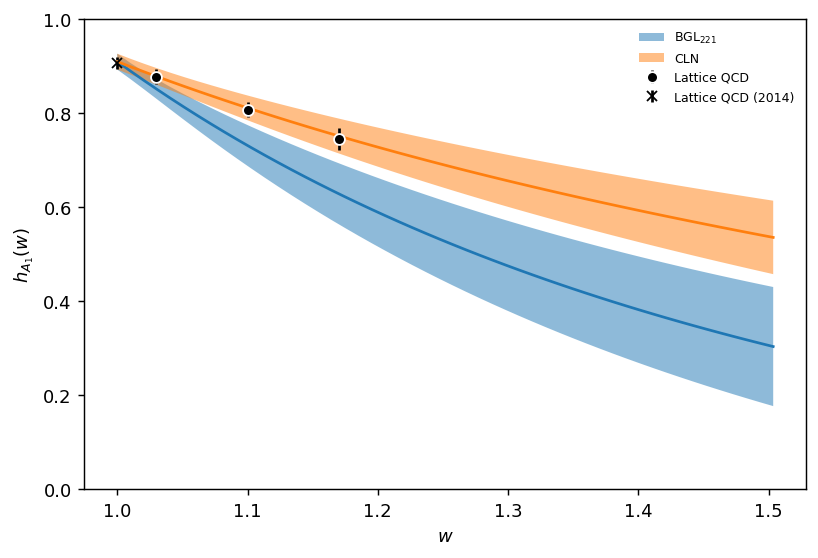

In [75]:
ff_hA1_BGL = [rate_bgl.FF.h_A1(w)  for w in w_range]
ff_hA1_CLN = [rate_cln.FF.h_A1(w)  for w in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(w_range, unp.nominal_values(ff_hA1_BGL))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_hA1_BGL) + unp.std_devs(ff_hA1_BGL),
    unp.nominal_values(ff_hA1_BGL) - unp.std_devs(ff_hA1_BGL),
    alpha=0.5,
    label=r"BGL$_{221}$"
)

ax.plot(w_range, unp.nominal_values(ff_hA1_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_hA1_CLN) + unp.std_devs(ff_hA1_CLN),
    unp.nominal_values(ff_hA1_CLN) - unp.std_devs(ff_hA1_CLN),
    alpha=0.5,
    label="CLN"
)

ax.errorbar(
    x=[1.03, 1.10, 1.17],
    y=unp.nominal_values(hA1_all), 
    yerr=unp.std_devs(hA1_all), 
    marker="o", color="black", markeredgecolor="white", ls="",
    label="Lattice QCD"
)

ax.errorbar(
    x=[1.0],
    y=unp.nominal_values(hA1_2014), 
    yerr=unp.std_devs(hA1_2014), 
    marker="x", color="black", markeredgecolor="black", ls="",
    label="Lattice QCD (2014)"
)

ax.set_ylim(0, 1)
ax.set_ylabel(r"$h_{A_1}(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper right')

plt.tight_layout()
plt.show()
plt.close()

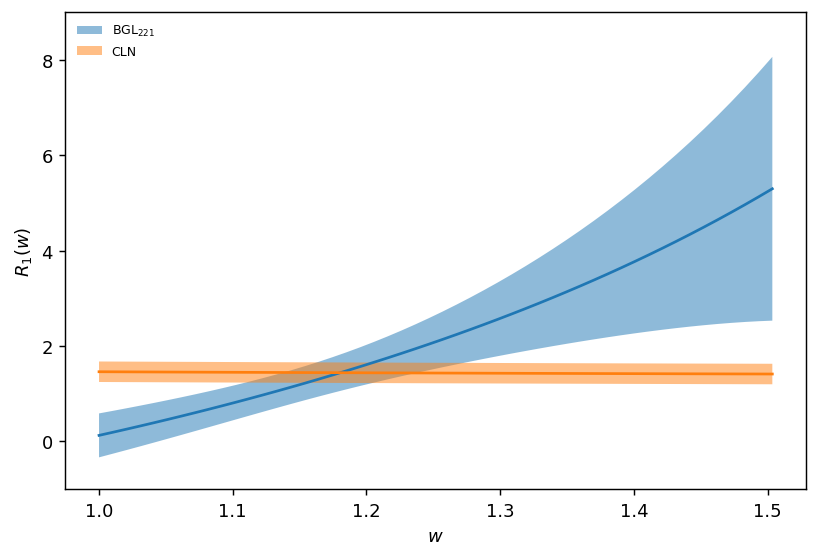

In [76]:
ff_R1_BGL = [rate_bgl.FF.R1(w)  for w in w_range]
ff_R1_CLN = [rate_cln.FF.R1(w)  for w in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(w_range, unp.nominal_values(ff_R1_BGL))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R1_BGL) + unp.std_devs(ff_R1_BGL),
    unp.nominal_values(ff_R1_BGL) - unp.std_devs(ff_R1_BGL),
    alpha=0.5,
    label=r"BGL$_{221}$"
)

ax.plot(w_range, unp.nominal_values(ff_R1_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R1_CLN) + unp.std_devs(ff_R1_CLN),
    unp.nominal_values(ff_R1_CLN) - unp.std_devs(ff_R1_CLN),
    alpha=0.5,
    label="CLN"
)

#ax.errorbar(
#    x=[1.03, 1.10, 1.17],
#    y=unp.nominal_values(hA1_all), 
#    yerr=unp.std_devs(hA1_all), 
#    marker="o", color="black", markeredgecolor="white", ls="",
#    label="Lattice QCD"
#)

ax.set_ylim(-1, 9)
ax.set_ylabel(r"$R_1(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

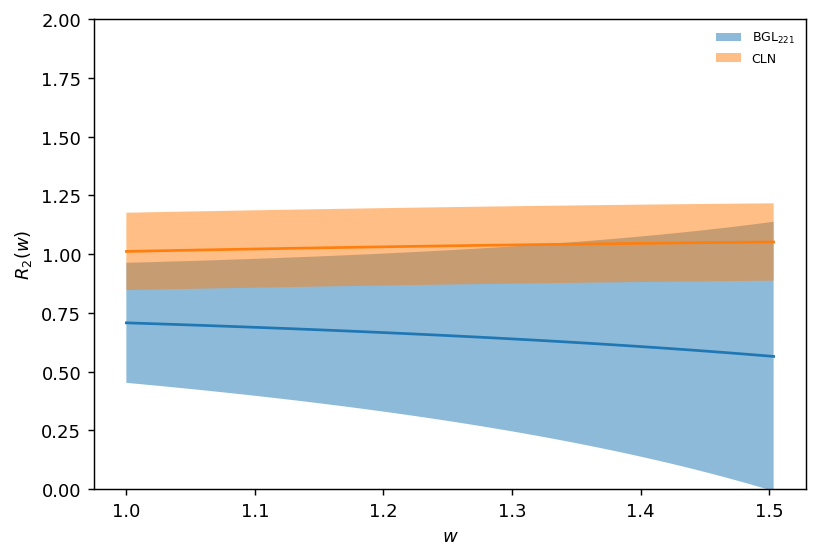

In [77]:
ff_R2_BGL = [rate_bgl.FF.R2(w)  for w in w_range]
ff_R2_CLN = [rate_cln.FF.R2(w)  for w in w_range]

fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ax.plot(w_range, unp.nominal_values(ff_R2_BGL))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R2_BGL) + unp.std_devs(ff_R2_BGL),
    unp.nominal_values(ff_R2_BGL) - unp.std_devs(ff_R2_BGL),
    alpha=0.5,
    label=r"BGL$_{221}$"
)

ax.plot(w_range, unp.nominal_values(ff_R2_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_R2_CLN) + unp.std_devs(ff_R2_CLN),
    unp.nominal_values(ff_R2_CLN) - unp.std_devs(ff_R2_CLN),
    alpha=0.5,
    label="CLN"
)

#ax.errorbar(
#    x=[1.03, 1.10, 1.17],
#    y=unp.nominal_values(hA1_all), 
#    yerr=unp.std_devs(hA1_all), 
#    marker="o", color="black", markeredgecolor="white", ls="",
#    label="Lattice QCD"
#)

ax.set_ylim(0, 2)
ax.set_ylabel(r"$R_2(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper right')

plt.tight_layout()
plt.show()
plt.close()

In [91]:
import warnings
warnings.filterwarnings(action='once')
bgl_coefficient_test = {}

In [92]:
def chi2_normalized_minuit(a0, a1, a2, b0, b1, b2, c1, c2, c3):
    Vcb = 1
    chi2 = 0
    for channel in [15]: #channels:
        delta = data[channel]["central_fit"][:-1] - transform(drop(theory_normalized(np.array([a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb]), channel)))[:-1]
        chi2 += delta @ data[channel]["inv_covariance_fit"][:-1, :-1] @ delta 
    chi2 += theory_term(rate[channel], a0, a1, a2, b0, b1, b2, c1, c2, c3, Vcb)
    return chi2

chi2_normalized_minuit(0, 0, 0, 0, 0, 0, 0, 0, 0)

/home/mapr/projects/eFFORT2/effort2/formfactors/BGL.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return (w + 1) * self.m_B * self.m_V * self.g(z) / self.f(z)


nan

In [93]:
bgl_coefficient_test.keys()

dict_keys([])

In [94]:
for a in range(0, 4):
    for b in range(0, 2):
        for c in range(0, 4):
            print(f"Running BGL {a}{b}{c}")
            m_test = Minuit(chi2_normalized_minuit, 
               a0=coefficients[0].n if a >= 1 else 0,
               a1=coefficients[1].n if a >= 2 else 0,
               a2=0,
               b0=coefficients[2].n if b >= 1 else 0,
               b1=coefficients[3].n if b >= 2 else 0,
               b2=0,
               c1=coefficients[4].n if c >= 1 else 0,
               c2=0,
               c3=0
              )

            m_test.fixed["a0"] = True if a <= 0 else False
            m_test.fixed["b0"] = True if b <= 0 else False
            m_test.fixed["c1"] = True if c <= 0 else False

            m_test.fixed["a1"] = True if a <= 1 else False
            m_test.fixed["b1"] = True if b <= 1 else False
            m_test.fixed["c2"] = True if c <= 1 else False

            m_test.fixed["a2"] = True if a <= 2 else False
            m_test.fixed["b2"] = True if b <= 2 else False
            m_test.fixed["c3"] = True if c <= 2 else False
            
            m_test.limits["b0"] = (1e-5, None)
            m_test.migrad()  # run optimiser
            m_test.hesse()   # run covariance estimator
            bgl_coefficient_test[f"{a}{b}{c}"] = m_test
            print(f"Result for BGL {a}{b}{c}")
            print(m_test.fixed)
            print(f"$\chi^2$ / ndf = {m_test.fval:.1f} / {36 - a - b - c}")
            print(f"p = {scipy.stats.chi2.sf(m_test.fval, df=36 - a - b - c):.2f}")

<>:35: DeprecationWarning: invalid escape sequence \c


Running BGL 000
Result for BGL 000
<FixedView a0=True a1=True a2=True b0=True b1=True b2=True c1=True c2=True c3=True>
$\chi^2$ / ndf = 3060.7 / 36
p = 0.00
Running BGL 001
Result for BGL 001
<FixedView a0=True a1=True a2=True b0=True b1=True b2=True c1=False c2=True c3=True>
$\chi^2$ / ndf = 4815.1 / 35
p = 0.00
Running BGL 002
Result for BGL 002
<FixedView a0=True a1=True a2=True b0=True b1=True b2=True c1=False c2=False c3=True>
$\chi^2$ / ndf = 3565.6 / 34
p = 0.00
Running BGL 003
Result for BGL 003
<FixedView a0=True a1=True a2=True b0=True b1=True b2=True c1=False c2=False c3=False>
$\chi^2$ / ndf = 3482.4 / 33
p = 0.00
Running BGL 010
Result for BGL 010
<FixedView a0=True a1=True a2=True b0=False b1=True b2=True c1=True c2=True c3=True>
$\chi^2$ / ndf = 145.7 / 35
p = 0.00
Running BGL 011
Result for BGL 011
<FixedView a0=True a1=True a2=True b0=False b1=True b2=True c1=False c2=True c3=True>
$\chi^2$ / ndf = 327.6 / 34
p = 0.00
Running BGL 012
Result for BGL 012
<FixedView a0=Tr

/tmp/ipykernel_72770/548968569.py:30: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_test.migrad()  # run optimiser
/tmp/ipykernel_72770/548968569.py:31: IMinuitWarning: Hesse called with all parameters fixed
  m_test.hesse()   # run covariance estimator


Result for BGL 103
<FixedView a0=False a1=True a2=True b0=True b1=True b2=True c1=False c2=False c3=False>
$\chi^2$ / ndf = 2965.3 / 32
p = 0.00
Running BGL 110
Result for BGL 110
<FixedView a0=False a1=True a2=True b0=False b1=True b2=True c1=True c2=True c3=True>
$\chi^2$ / ndf = 2953.1 / 34
p = 0.00
Running BGL 111
Result for BGL 111
<FixedView a0=False a1=True a2=True b0=False b1=True b2=True c1=False c2=True c3=True>
$\chi^2$ / ndf = 175.7 / 33
p = 0.00
Running BGL 112
Result for BGL 112
<FixedView a0=False a1=True a2=True b0=False b1=True b2=True c1=False c2=False c3=True>
$\chi^2$ / ndf = 35.0 / 32
p = 0.33
Running BGL 113
Result for BGL 113
<FixedView a0=False a1=True a2=True b0=False b1=True b2=True c1=False c2=False c3=False>
$\chi^2$ / ndf = 33.2 / 31
p = 0.36
Running BGL 200
Result for BGL 200
<FixedView a0=False a1=False a2=True b0=True b1=True b2=True c1=True c2=True c3=True>
$\chi^2$ / ndf = 2953.0 / 34
p = 0.00
Running BGL 201
Result for BGL 201
<FixedView a0=False a1=F

In [95]:
for a in range(0, 4):
    for b in range(0, 4):
        for c in range(0, 4):
            index = f"{a}{b}{c}"
            print(f"BGL{a}{b}{c} $\chi^2$ / ndf = {bgl_coefficient_test[index].fval:.1f} / {36 - a - b - c}")

BGL000 $\chi^2$ / ndf = 3060.7 / 36
BGL001 $\chi^2$ / ndf = 4815.1 / 35
BGL002 $\chi^2$ / ndf = 3565.6 / 34
BGL003 $\chi^2$ / ndf = 3482.4 / 33
BGL010 $\chi^2$ / ndf = 145.7 / 35
BGL011 $\chi^2$ / ndf = 327.6 / 34
BGL012 $\chi^2$ / ndf = 166.3 / 33
BGL013 $\chi^2$ / ndf = 155.8 / 32


KeyError: '020'

In [ ]:
foobar = {}
for a in range(1, 4):
    for b in range(1, 4):
        for c in range(1, 4):
            index = f"{a}{b}{c}"
            if np.isnan(bgl_coefficient_test[index].fval): continue
            tmp = correlated_values(np.array(bgl_coefficient_test[index].values), np.array(bgl_coefficient_test[index].covariance))
            foobar[index] = np.array([bgl_coefficient_test[index].fval, 36 - a - b - c, *tmp])
            
pd.DataFrame.from_dict(foobar, columns=["chi2", "ndf", "a0", "a1", "a2", "b0", "b1", "b2", "c0", "c1", "c2",], orient="index").applymap(lambda x: f"{x:.5f}")

In [ ]:
from treelib import Node, Tree

tree = Tree()
tree.create_node("Scan", "scan")
for i in range(10):
    tree.create_node(f"n={i}", f"n{i}", parent="scan")
    
for a in range(1, 4):
    for b in range(1, 4):
        for c in range(1, 4):
            index = f"{a}{b}{c}"
            if np.isnan(bgl_coefficient_test[index].fval): continue
            tree.create_node(f"{index}: {bgl_coefficient_test[index].fval:.1f} / {36 - a - b - c}", index, parent=f"n{a+b+c}")

tree.show()

In [ ]:
assert False

In [ ]:
w_range = np.linspace(*bToDStarBGL.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarBGL.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarBGL.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarBGL.kinematics.chi_range)

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()


fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

result = get_full_spectrum(m_average)

ax.errorbar(
    x=[x for x in range(0, 40)],
    y=unp.nominal_values(result) / tmp_bw ,
    yerr=unp.std_devs(result) / tmp_bw,
    marker='o', color="black", ls="", markeredgecolor='white', label=r"$B \to D^* \ell \nu_\ell$",
)

for a in range(1, 3):
    for b in range(1, 3):
        for c in range(0, 2):
            index = f"{a}{b}{c}"
            if np.isnan(bgl_coefficient_test[index].fval): continue
            coefficients_loop = np.array([*bgl_coefficient_test[index].values])
            bToDStarBGL_loop = BToDStarBGL(
                m_B=5.27963,
                m_V=2.01026,
                exp_coeff_a = coefficients_loop[0:3],
                exp_coeff_b = coefficients_loop[3:6],
                exp_coeff_c = coefficients_loop[6:9],
            )

            rate_bgl_loop = BtoV(bToDStarBGL_loop, 1)
            print(index, rate_bgl_loop.Gamma())

            total_rate = rate_bgl_loop.Gamma()
            w_rate = [rate_bgl_loop.dGamma_dw(w) / total_rate       * (max(w_range) - min(w_range))       for w in w_range]
            cosL_rate = [rate_bgl_loop.dGamma_dcosL(w) / total_rate * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
            cosV_rate = [rate_bgl_loop.dGamma_dcosV(w) / total_rate * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
            chi_rate = [rate_bgl_loop.dGamma_dchi(w) / total_rate   * (max(chi_range) - min(chi_range))   for w in chi_range]

            ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate), label=f"BGL$_{{{index}}}$ $\chi^2 = {{{bgl_coefficient_test[index].fval:.1f}}}$")
            ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate), color=plt.gca().lines[-1].get_color())
            ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate), color=plt.gca().lines[-1].get_color())
            ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate), color=plt.gca().lines[-1].get_color())

coefficients_loop = np.array([*bgl_coefficient_test[f"121"].values])
bToDStarBGL_loop = BToDStarBGL(
    m_B=5.27963,
    m_V=2.01026,
    exp_coeff_a = coefficients_loop[0:3],
    exp_coeff_b = coefficients_loop[3:6][:1],
    exp_coeff_c = coefficients_loop[6:9],
)

rate_bgl_loop = BtoV(bToDStarBGL_loop, 1)
print(index, rate_bgl_loop.Gamma())

total_rate = rate_bgl_loop.Gamma()
w_rate = [rate_bgl_loop.dGamma_dw(w) / total_rate       * (max(w_range) - min(w_range))       for w in w_range]
cosL_rate = [rate_bgl_loop.dGamma_dcosL(w) / total_rate * (max(cosL_range) - min(cosL_range)) for w in cosL_range]
cosV_rate = [rate_bgl_loop.dGamma_dcosV(w) / total_rate * (max(cosV_range) - min(cosV_range)) for w in cosV_range]
chi_rate = [rate_bgl_loop.dGamma_dchi(w) / total_rate   * (max(chi_range) - min(chi_range))   for w in chi_range]

ax.plot(np.linspace( 0-0.5, 10-0.5), unp.nominal_values(w_rate), label=f"BGL$_{{1(2)1}}$ $\chi^2 = {{{bgl_coefficient_test[index].fval:.1f}}}$")
ax.plot(np.linspace(10-0.5, 20-0.5), unp.nominal_values(cosL_rate), color=plt.gca().lines[-1].get_color())
ax.plot(np.linspace(20-0.5, 30-0.5), unp.nominal_values(cosV_rate), color=plt.gca().lines[-1].get_color())
ax.plot(np.linspace(30-0.5, 40-0.5), unp.nominal_values(chi_rate), color=plt.gca().lines[-1].get_color())
            
make_plot_pretty(ax, bin_edges_all)
ax.set_ylim(0, 2)
ax.set_ylabel(r"$(\mathcal{M}$) $1 / \Gamma \mathrm{d} \Gamma / \mathrm{d}x$")
#ax.text(1, 1.75, f"BGL", size="x-small")
#ax.text(1, 1.65, f"$\chi^2$ / ndf = {m.fval:.1f} / 30", size="x-small")
#ax.text(1, 1.55, f"p = {scipy.stats.chi2.sf(m.fval, df=36-6):.2f}", size="x-small")

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
w_range = np.linspace(*bToDStarBGL.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarBGL.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarBGL.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarBGL.kinematics.chi_range)

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()


fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))


ax.errorbar(
    x=[1.03, 1.10, 1.17],
    y=unp.nominal_values(hA1_all), 
    yerr=unp.std_devs(hA1_all), 
    marker="o", color="black", markeredgecolor="white", ls="",
    label="Lattice QCD"
)


ax.errorbar(
    x=[1.0],
    y=unp.nominal_values(hA1_2014), 
    yerr=unp.std_devs(hA1_2014), 
    marker="x", color="black", markeredgecolor="black", ls="",
    label="Lattice QCD (2014)"
)


ff_hA1_CLN = [rate_cln.FF.h_A1(w)  for w in w_range]
ax.plot(w_range, unp.nominal_values(ff_hA1_CLN))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff_hA1_CLN) + unp.std_devs(ff_hA1_CLN),
    unp.nominal_values(ff_hA1_CLN) - unp.std_devs(ff_hA1_CLN),
    alpha=0.5,
    label="CLN"
)
        
for a in range(1, 2):
    for b in range(1, 3):
        for c in range(1, 2):
            index = f"{a}{b}{c}"
            if np.isnan(bgl_coefficient_test[index].fval): continue
            coefficients_loop = np.array([*bgl_coefficient_test[index].values])
            bToDStarBGL_loop = BToDStarBGL(
                m_B=5.27963,
                m_V=2.01026,
                exp_coeff_a = coefficients_loop[0:3],
                exp_coeff_b = coefficients_loop[3:6],
                exp_coeff_c = coefficients_loop[6:9],
            )

            rate_bgl_loop = BtoV(bToDStarBGL_loop, 1)


            ff_hA1_BGL = [rate_bgl_loop.FF.h_A1(w)  for w in w_range]
            

            ax.plot(w_range, unp.nominal_values(ff_hA1_BGL))
            ax.fill_between(
                w_range, 
                unp.nominal_values(ff_hA1_BGL) + unp.std_devs(ff_hA1_BGL),
                unp.nominal_values(ff_hA1_BGL) - unp.std_devs(ff_hA1_BGL),
                alpha=0.5,
                label=f"BGL$_{{{index}}}$ $\chi^2 = {{{bgl_coefficient_test[index].fval:.1f}}}$"
            )



ax.set_ylim(0, 1)
ax.set_ylabel(r"$h_{A_1}(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='lower left')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
w_range = np.linspace(*bToDStarBGL.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarBGL.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarBGL.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarBGL.kinematics.chi_range)

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()


fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ff = [rate_cln.FF.R1(w)  for w in w_range]
ax.plot(w_range, unp.nominal_values(ff))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff) + unp.std_devs(ff),
    unp.nominal_values(ff) - unp.std_devs(ff),
    alpha=0.5,
    label="CLN"
)
        
for a in range(1, 2):
    for b in range(1, 3):
        for c in range(1, 2):
            index = f"{a}{b}{c}"
            if np.isnan(bgl_coefficient_test[index].fval): continue
            coefficients_loop = np.array([*bgl_coefficient_test[index].values])
            bToDStarBGL_loop = BToDStarBGL(
                m_B=5.27963,
                m_V=2.01026,
                exp_coeff_a = coefficients_loop[0:3],
                exp_coeff_b = coefficients_loop[3:6],
                exp_coeff_c = coefficients_loop[6:9],
            )

            rate_bgl_loop = BtoV(bToDStarBGL_loop, 1)


            ff = [rate_bgl_loop.FF.R1(w)  for w in w_range]
            

            ax.plot(w_range, unp.nominal_values(ff))
            ax.fill_between(
                w_range, 
                unp.nominal_values(ff) + unp.std_devs(ff),
                unp.nominal_values(ff) - unp.std_devs(ff),
                alpha=0.5,
                label=f"BGL$_{{{index}}}$ $\chi^2 = {{{bgl_coefficient_test[index].fval:.1f}}}$"
            )



ax.set_ylim(-1, 9)
ax.set_ylabel(r"$R_1(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
w_range = np.linspace(*bToDStarBGL.kinematics.w_range_numerical_stable)
cosL_range = np.linspace(*bToDStarBGL.kinematics.cosL_range)
cosV_range = np.linspace(*bToDStarBGL.kinematics.cosV_range)
chi_range = np.linspace(*bToDStarBGL.kinematics.chi_range)

tmp_bw =  np.array([
    [abs(u-l) / (max(w_range) - min(w_range))       for l, u in zip(wbins["B0"], wbins["B0"][1:])],
    [abs(u-l) / (max(cosL_range) - min(cosL_range)) for l, u in zip(cosLbins["B0"], cosLbins["B0"][1:])],
    [abs(u-l) / (max(cosV_range) - min(cosV_range)) for l, u in zip(cosVbins["B0"], cosVbins["B0"][1:])],
    [abs(u-l) / (max(chi_range) - min(chi_range))   for l, u in zip(chibins["B0"], chibins["B0"][1:])],
]).flatten()


fig, ax = plt.subplots(dpi=130, figsize=(6.4, 4.4))

ff = [rate_cln.FF.R2(w)  for w in w_range]
ax.plot(w_range, unp.nominal_values(ff))
ax.fill_between(
    w_range, 
    unp.nominal_values(ff) + unp.std_devs(ff),
    unp.nominal_values(ff) - unp.std_devs(ff),
    alpha=0.5,
    label="CLN"
)
        
for a in range(1, 2):
    for b in range(1, 3):
        for c in range(1, 2):
            index = f"{a}{b}{c}"
            if np.isnan(bgl_coefficient_test[index].fval): continue
            coefficients_loop = np.array([*bgl_coefficient_test[index].values])
            bToDStarBGL_loop = BToDStarBGL(
                m_B=5.27963,
                m_V=2.01026,
                exp_coeff_a = coefficients_loop[0:3],
                exp_coeff_b = coefficients_loop[3:6],
                exp_coeff_c = coefficients_loop[6:9],
            )

            rate_bgl_loop = BtoV(bToDStarBGL_loop, 1)


            ff = [rate_bgl_loop.FF.R2(w)  for w in w_range]
            

            ax.plot(w_range, unp.nominal_values(ff))
            ax.fill_between(
                w_range, 
                unp.nominal_values(ff) + unp.std_devs(ff),
                unp.nominal_values(ff) - unp.std_devs(ff),
                alpha=0.5,
                label=f"BGL$_{{{index}}}$ $\chi^2 = {{{bgl_coefficient_test[index].fval:.1f}}}$"
            )



#ax.set_ylim(0, 2)
ax.set_ylabel(r"$R_2(w)$")
ax.set_xlabel(r"$w$")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper right')

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
assert False

In [ ]:
results = {}
for channel in channels:
    
    def chi2_normalized_minuit(a0, a1, b0, b1, c1, c2):
        Vcb = 1
        delta = data[channel]["central_fit"][:-1] - transform(drop(theory_normalized(np.array([a0, a1, b0, b1, c1, c2, Vcb]), channel)))[:-1]
        invC = data[channel]["inv_covariance_fit"][:-1, :-1]
        return delta @ invC @ delta + theory_term(rate[channel], a0, a1, b0, b1, c1, c2, Vcb)
    
    m = Minuit(chi2_normalized_minuit, 
               a0=test[0],
               a1=test[1],
               b0=test[2],
               b1=test[3],
               c1=test[4],
               c2=test[5]
              )

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    results[channel] = m
    print(m)

In [ ]:
results = {}
for channel in channels:
    
    def chi2_normalized_minuit(a0, a1, b0, b1, c1, c2, Vcb):
        delta = data[channel]["central_fit"] - transform(drop(theory_normalized(np.array([a0, a1, b0, b1, c1, c2, Vcb]), channel)))
        invC = data[channel]["inv_covariance_fit"]
        return delta @ invC @ delta + theory_term(rate[channel], a0, a1, b0, b1, c1, c2, Vcb)
    
    m = Minuit(chi2_normalized_minuit, 
               a0=test[0],
               a1=test[1],
               b0=test[2],
               b1=test[3],
               c1=test[4],
               c2=test[5],
               Vcb=test[6],
              )

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    results[channel] = m
    print(m)

In [ ]:
# all
def chi2_normalized_minuit(a0, a1, b0, b1, c1, c2, Vcb):
    chi2 = 0
    for channel in channels:
        delta = data[channel]["central_fit"] - transform(drop(theory_normalized(np.array([a0, a1, b0, b1, c1, c2, Vcb]), channel)))
        chi2 += delta @ data[channel]["inv_covariance_fit"] @ delta 
    chi2 += theory_term(rate[channel], a0, a1, b0, b1, c1, c2, Vcb)
    return chi2

m = Minuit(chi2_normalized_minuit, 
           a0=test[0],
           a1=test[1],
           b0=test[2],
           b1=test[3],
           c1=test[4],
           c2=test[5],
           Vcb=test[6]
          )

m.migrad()  # run optimiser
m.hesse()   # run covariance estimator
results["all"] = m
print(m)

In [ ]:
vcb_fit_results = {}
scenarios = channels #+ ["B0", "B+"]

for channel in scenarios:
    # Set the rate calculator with the most recent values
    x = correlated_values(results[channel].values, np.array(results[channel].covariance))
    rate[channel].Vcb = x[6]
    Vcb = x[6]
    # rate[channel].eta_EW = 1
    rate[channel].FF.set_expansion_coefficients(x[:2], x[2:4], x[4:6])
    
    # b0 = ufloat(results[channel].values[2], results[channel].covariance[2, 2]**0.5)
    # Vcb = 1 / 2 / (rate[channel].mB * rate[channel].mV) ** 0.5 * (b0 / rate[channel].FF.phi_f(0) / rate[channel].FF.blaschke_factor_axialvector(0))
    if channel in [15, 16, "B0"]:
        tau = tauBzero
    elif channel in [17, 18, "B+"]:
        tau = tauBplus

    df = len(data[channel]["central_fit"]) - results[channel].nfit
    vcb_fit_results[channel_label[channel]] = {
        "BR [%]": f"{100*rate[channel].Gamma() * tau:.2f}",
        r"$|V_\mathrm{cb}|$ [$10^3$]": 1e3 * x[6],
        # r"|Vcb| $\eta_\mathrm{EW}$ $\mathcal{F}(1)$ [$10^3$]": 1e3 * Vcb,
        "Uncertainty [%]": f"{100*Vcb.std_dev / Vcb.nominal_value:.2f}",
        r"$\chi^2$ / dof": f"{results[channel].fval:.2f} / {df:.0f}",
        r"p": f"{scipy.integrate.quad(lambda x: scipy.stats.chi2(df=df).pdf(x), results[channel].fval, np.inf)[0]:0f}"
    }
    
pd.DataFrame(vcb_fit_results).transpose()

In [ ]:
scenarios = channels #+ ["B0", "B+"] #+ ["all"]
parameters = [r"$a_0$", r"$a_1$", r"$b_0$", r"$b_1$", r"$c_1$", r"$c_2$"]

for i, parmater in enumerate(parameters):
    plt.figure(dpi=100)
    ax = plt.gca()
    x = 1e3 * np.array([
        correlated_values(results[channel].values, np.array(results[channel].covariance))[i]
        for channel in scenarios
    ])
    
    ax.errorbar(
        x=range(len(x)), 
        y=unp.nominal_values(x),
        yerr=unp.std_devs(x),
        marker=".", ls="", label=channel_label[channel])
    #ax.axhline(0, ls=":", lw=1, color="black")
    ax.set_ylabel(f"{parameters[i]} $\\times 10^3$")
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels([channel_label[channel] for channel in scenarios], rotation=90)
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# vcb_fit_results = {}
# for channel in ["e", "mu", "all"]:
#     # Set the rate calculator with the most recent values
#     #x = correlated_values(results[channel].values, np.array(results[channel].covariance))
#     #rate[channel].Vcb = 1
#     #rate[channel].eta_EW = 1
#     #rate[channel].FF.set_expansion_coefficients(x[:2], x[2:4], x[4:])
#     
#     #b0 = ufloat(results[channel].values[2], results[channel].covariance[2, 2]**0.5)
#     #Vcb = 1 / 2 / (rate[channel].mB * rate[channel].mV) ** 0.5 * (b0 / rate[channel].FF.phi_f(0) / rate[channel].FF.blaschke_factor_axialvector(0))
#     #if channel in [15, 16]:
#     #    tau = tauBzero
#     #elif channel in [17, 18]:
#     #    tau = tauBplus
# 
#     df = len(data[15]["central_fit"]) - results[channel].nfit
#     vcb_fit_results[channel_label[channel]] = {
#         #"BR [%]": f"{100*rate[channel].Gamma() * tau:.2f}",
#         #r"|Vcb| $\eta_\mathrm{EW}$ $\mathcal{F}(1)$ [$10^3$]": 1e3*Vcb,
#         #"Uncertainty [%]": f"{100*Vcb.std_dev / Vcb.nominal_value:.2f}",
#         r"$\chi^2$ / dof": f"{results[channel].fval:.2f} / {df:.0f}",
#         r"p": f"{scipy.integrate.quad(lambda x: scipy.stats.chi2(df=df).pdf(x), results[channel].fval, np.inf)[0]:0f}"
#     }
#     
# pd.DataFrame(vcb_fit_results).transpose()

In [ ]:
plt.figure(dpi=100)

for channel in ["B+", "B0"]:
    x = correlated_values(results[channel].values, np.array(results[channel].covariance))
    r = rate[channel]
    r.Vcb = x[6]
    r.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:6])
    
    ax = plt.gca()
    x = np.linspace(r.w_min, r.w_max)
    y = np.array([r.FF.h_A1(w) for w in x])    
    ax.plot(x, unp.nominal_values(y), label=channel_label[channel])
    ax.fill_between(x, unp.nominal_values(y) - unp.std_devs(y), unp.nominal_values(y) + unp.std_devs(y), alpha=0.3)
    ax.set_xlabel(r"$w$ [1]")
    ax.set_ylabel(r"$h_{A_1}$ [1]")

ax.errorbar(1, y=hA1.n, yerr=hA1.s, color="black", marker=".", ls="", label="LQCD")
ax.errorbar(np.array([1.03, 1.10, 1.17]), y=unp.nominal_values(hA1_all), yerr=unp.std_devs(hA1_all), color="black", marker="x", ls="", label="LQCD")
ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
for channel in ["B0", "B+"]:
    x = correlated_values(results[channel].values, np.array(results[channel].covariance))
    r = rate[channel]
    r.Vcb = x[6]
    r.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:6])
    gamma = r.Gamma()
    
    plt.figure(dpi=130, figsize=(6.4, 4.4))
    ax = plt.gca()
    
    # Theory
    x = np.linspace(r.w_min, r.w_max)
    y = np.array([r.dGamma_dw(w) / gamma for w in x])  
    ax.plot(x, unp.nominal_values(y), label=channel_label[channel])
    ax.fill_between(x, unp.nominal_values(y) - unp.std_devs(y), unp.nominal_values(y) + unp.std_devs(y), alpha=0.3)
    # Data
    bin_center = np.array([a + (b-a) / 2 for a, b in zip(wbins[channel], wbins[channel][1:])])
    bin_widths = np.array([(b-a) for a, b in zip(wbins[channel], wbins[channel][1:])])
    y = data[channel]["central"][0:10] / bin_widths
    yerr = data[channel]["covariance"].diagonal()[0:10]**0.5 / bin_widths
    ax.errorbar(
        x=bin_center, 
        y=y, 
        yerr=yerr,
        ls="", marker=".", color="black", label="Asimov Data"
    )


    ax.set_xlabel(r"$w$ [1]")
    ax.set_ylabel(r"$\Delta \Gamma / \Gamma$ in arb. units")
    ax.set_ylim(0, 3)

    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

    parent_axes = plt.gca()
    inside_axis = inset_axes(parent_axes,
                        width="30%", # width = 30% of parent_bbox
                        height=0.3, # height : 1 inch
                        loc=1)

    # inside_axis.errorbar(1e15*t_normalized_postfit[-1] , 0, marker="x", color="tab:blue")
    inside_axis.axvline(1e15*gamma.n, color="tab:blue")
    inside_axis.fill_betweenx([-0.1, 0.1], 1e15*(gamma.n-gamma.s), 1e15*(gamma.n+gamma.s), color="tab:blue", alpha=0.3)
    inside_axis.errorbar(1e15*data[channel]["central"][-1], 0, xerr=1e15*data[channel]["covariance"].diagonal()[-1]**0.5,  marker=".", color="black")
    #inside_axis.set_xlim(20.8, 24.2)
    #inside_axis.set_xticks(range(21, 24+1))
    inside_axis.set_ylim(-0.1, 0.1)
    #inside_axis.set_yticklabels([])
    inside_axis.set_yticks([])
    inside_axis.set_xlabel(r"$\Gamma \times 10^{15}$")

    ax.set_title(channel_label[channel])
    plt.savefig(f"vcb{channel}_w.pdf")
    plt.show()
    plt.close()

In [ ]:
for channel in ["B0", "B+"]:
    x = correlated_values(results[channel].values, np.array(results[channel].covariance))
    r = rate[channel]
    r.Vcb = x[6]
    r.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:6])
    gamma = r.Gamma()
    
    plt.figure(dpi=130, figsize=(6.4, 4.4))
    ax = plt.gca()
    
    # Theory
    x = np.linspace(r.cosL_min, r.cosL_max)
    y = np.array([r.dGamma_dcosL(w) / gamma for w in x])  
    ax.plot(x, unp.nominal_values(y), label=channel_label[channel])
    ax.fill_between(x, unp.nominal_values(y) - unp.std_devs(y), unp.nominal_values(y) + unp.std_devs(y), alpha=0.3)
    # Data
    bin_center = np.array([a + (b-a) / 2 for a, b in zip(cosLbins[channel], cosLbins[channel][1:])])
    bin_widths = np.array([(b-a) for a, b in zip(cosLbins[channel], cosLbins[channel][1:])])
    y = data[channel]["central"][10:20] / bin_widths
    yerr = data[channel]["covariance"].diagonal()[10:20]**0.5 / bin_widths
    ax.errorbar(
        x=bin_center, 
        y=y, 
        yerr=yerr,
        ls="", marker=".", color="black", label="Asimov Data"
    )


    ax.set_xlabel(r"$\cos\theta_\ell$ [1]")
    ax.set_ylabel(r"$\Delta \Gamma / \Gamma$ in arb. units")
    ax.set_ylim(0, 1.5)

    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

    parent_axes = plt.gca()
    inside_axis = inset_axes(parent_axes,
                        width="30%", # width = 30% of parent_bbox
                        height=0.3, # height : 1 inch
                        loc=1)

    # inside_axis.errorbar(1e15*t_normalized_postfit[-1] , 0, marker="x", color="tab:blue")
    inside_axis.axvline(1e15*gamma.n, color="tab:blue")
    inside_axis.fill_betweenx([-0.1, 0.1], 1e15*(gamma.n-gamma.s), 1e15*(gamma.n+gamma.s), color="tab:blue", alpha=0.3)
    inside_axis.errorbar(1e15*data[channel]["central"][-1], 0, xerr=1e15*data[channel]["covariance"].diagonal()[-1]**0.5,  marker=".", color="black")
    #inside_axis.set_xlim(20.8, 24.2)
    #inside_axis.set_xticks(range(21, 24+1))
    inside_axis.set_ylim(-0.1, 0.1)
    #inside_axis.set_yticklabels([])
    inside_axis.set_yticks([])
    inside_axis.set_xlabel(r"$\Gamma \times 10^{15}$")

    ax.set_title(channel_label[channel])
    plt.savefig(f"vcb{channel}_cosL.pdf")
    plt.show()
    plt.close()

In [ ]:
for channel in ["B0", "B+"]:
    x = correlated_values(results[channel].values, np.array(results[channel].covariance))
    r = rate[channel]
    r.Vcb = x[6]
    r.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:6])
    gamma = r.Gamma()
    
    plt.figure(dpi=130, figsize=(6.4, 4.4))
    ax = plt.gca()
    
    # Theory
    x = np.linspace(r.cosV_min, r.cosV_max)
    y = np.array([r.dGamma_dcosV(w) / gamma for w in x])  
    ax.plot(x, unp.nominal_values(y), label=channel_label[channel])
    ax.fill_between(x, unp.nominal_values(y) - unp.std_devs(y), unp.nominal_values(y) + unp.std_devs(y), alpha=0.3)
    # Data
    bin_center = np.array([a + (b-a) / 2 for a, b in zip(cosVbins[channel], cosVbins[channel][1:])])
    bin_widths = np.array([(b-a) for a, b in zip(cosVbins[channel], cosVbins[channel][1:])])
    y = data[channel]["central"][20:30] / bin_widths
    yerr = data[channel]["covariance"].diagonal()[20:30]**0.5 / bin_widths
    ax.errorbar(
        x=bin_center, 
        y=y, 
        yerr=yerr,
        ls="", marker=".", color="black", label="Asimov Data"
    )


    ax.set_xlabel(r"$\cos\theta_V$ [1]")
    ax.set_ylabel(r"$\Delta \Gamma / \Gamma$ in arb. units")
    ax.set_ylim(0, 1.5)

    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

    parent_axes = plt.gca()
    inside_axis = inset_axes(parent_axes,
                        width="30%", # width = 30% of parent_bbox
                        height=0.3, # height : 1 inch
                        loc=1)

    # inside_axis.errorbar(1e15*t_normalized_postfit[-1] , 0, marker="x", color="tab:blue")
    inside_axis.axvline(1e15*gamma.n, color="tab:blue")
    inside_axis.fill_betweenx([-0.1, 0.1], 1e15*(gamma.n-gamma.s), 1e15*(gamma.n+gamma.s), color="tab:blue", alpha=0.3)
    inside_axis.errorbar(1e15*data[channel]["central"][-1], 0, xerr=1e15*data[channel]["covariance"].diagonal()[-1]**0.5,  marker=".", color="black")
    #inside_axis.set_xlim(20.8, 24.2)
    #inside_axis.set_xticks(range(21, 24+1))
    inside_axis.set_ylim(-0.1, 0.1)
    #inside_axis.set_yticklabels([])
    inside_axis.set_yticks([])
    inside_axis.set_xlabel(r"$\Gamma \times 10^{15}$")

    ax.set_title(channel_label[channel])
    plt.savefig(f"vcb{channel}_cosV.pdf")
    plt.show()
    plt.close()

In [ ]:
for channel in ["B0", "B+"]:
    x = correlated_values(results[channel].values, np.array(results[channel].covariance))
    r = rate[channel]
    r.Vcb = x[6]
    r.FF.set_expansion_coefficients(x[:2], x[2:4], x[4:6])
    gamma = r.Gamma()
    
    plt.figure(dpi=130, figsize=(6.4, 4.4))
    ax = plt.gca()
    
    # Theory
    x = np.linspace(r.chi_min, r.chi_max)
    y = np.array([r.dGamma_dchi(w) / gamma for w in x])  
    ax.plot(x, unp.nominal_values(y), label=channel_label[channel])
    ax.fill_between(x, unp.nominal_values(y) - unp.std_devs(y), unp.nominal_values(y) + unp.std_devs(y), alpha=0.3)
    # Data
    bin_center = np.array([a + (b-a) / 2 for a, b in zip(chibins[channel], chibins[channel][1:])])
    bin_widths = np.array([(b-a) for a, b in zip(chibins[channel], chibins[channel][1:])])
    y = data[channel]["central"][30:40] / bin_widths
    yerr = data[channel]["covariance"].diagonal()[30:40]**0.5 / bin_widths
    ax.errorbar(
        x=bin_center, 
        y=y, 
        yerr=yerr,
        ls="", marker=".", color="black", label="Asimov Data"
    )


    ax.set_xlabel(r"$\chi$ [rad]")
    ax.set_ylabel(r"$\Delta \Gamma / \Gamma$ in arb. units")
    ax.set_ylim(0, 0.5)

    ax.legend(frameon=False, fontsize="x-small", ncol=1, loc='upper left')

    parent_axes = plt.gca()
    inside_axis = inset_axes(parent_axes,
                        width="30%", # width = 30% of parent_bbox
                        height=0.3, # height : 1 inch
                        loc=1)

    # inside_axis.errorbar(1e15*t_normalized_postfit[-1] , 0, marker="x", color="tab:blue")
    inside_axis.axvline(1e15*gamma.n, color="tab:blue")
    inside_axis.fill_betweenx([-0.1, 0.1], 1e15*(gamma.n-gamma.s), 1e15*(gamma.n+gamma.s), color="tab:blue", alpha=0.3)
    inside_axis.errorbar(1e15*data[channel]["central"][-1], 0, xerr=1e15*data[channel]["covariance"].diagonal()[-1]**0.5,  marker=".", color="black")
    #inside_axis.set_xlim(20.8, 24.2)
    #inside_axis.set_xticks(range(21, 24+1))
    inside_axis.set_ylim(-0.1, 0.1)
    #inside_axis.set_yticklabels([])
    inside_axis.set_yticks([])
    inside_axis.set_xlabel(r"$\Gamma \times 10^{15}$")

    ax.set_title(channel_label[channel])
    plt.savefig(f"vcb{channel}_chi.pdf")
    plt.show()
    plt.close()